# Brain Tumors MRI Images Segmentation CNN(AE)+LSTM



## Introduction

The goal of this work is to reimplement the CNN based LSTM,  a model which takes in the same time the spatial and temporal information. This design aims to improve the performance of 3D Brain tumors MRI images segementation. In particular, a set of brain slicing image could be considered as a sereis of moving image.

## Method


This experiments compare the result of segementation with Autoencoder, CNNbased LSTM, and its variation, Bidirectional CNN-LSTM. As a basical design, the model is composed of 3 part:
    1. CNN based encoder,
    2. LSTM Layers,
    3. CNN based decoder.
    
The model takes a series of MRI images of type T2 as input, and gives the shape of tumors on a background. The loss function is MSE for comparing two images. 

The set are split into 2 parts, 70% for training and 30% for test.



## Result

The current result shows that the Unet with LSTMCon2d layers could perform better than the original Unet. The following table represents the Dice score of lesion of four levels. It shows that the Dice score are improved in the 3 level except that in 1 level it has been slightly reduced. 

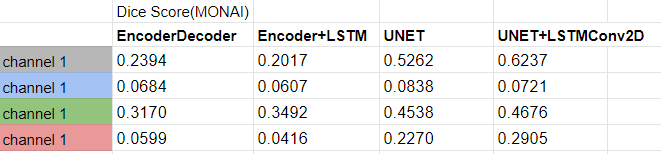

Sample ouput segementation

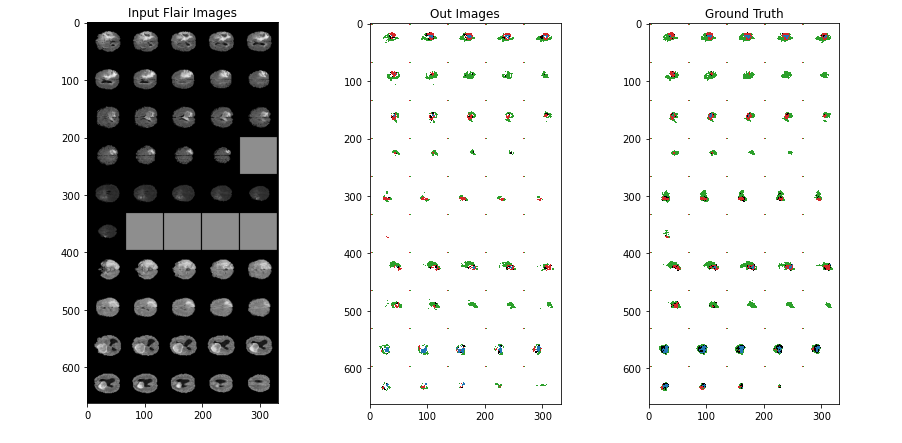

# Codes

In [1]:

from medical_outils import *
%reload_ext autoreload
%autoreload

In [2]:

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Read Images and Create Dataset

In [5]:
# Root directory for dataset
dataroot_Flair = "./BraTS2015_Medium/Flair/train"
dataroot_T1 = "./BraTS2015_Medium/T1/train"
dataroot_T1c = "./BraTS2015_Medium/T1c/train"
dataroot_T2 = "./BraTS2015_Medium/T2/train"
dataroot_OT = "./BraTS2015_Medium/OT/train"
dataroot_OT_Back = "./BraTS2015_Medium/OT_BACKGROUND/train"
dataroot_OT_4ch = "./BraTS2015_Medium/OT_4ch/train"

dataroot_Flair_test = "./BraTS2015_Medium/Flair/test"
dataroot_T1_test = "./BraTS2015_Medium/T1/test"
dataroot_T1c_test = "./BraTS2015_Medium/T1c/test"
dataroot_T2_test = "./BraTS2015_Medium/T2/test"
dataroot_OT_test = "./BraTS2015_Medium/OT/test"
dataroot_OT_Back_test = "./BraTS2015_Medium/OT_BACKGROUND/test"
dataroot_OT_4ch_test = "./BraTS2015_Medium/OT_4ch/test"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

#   size of fixed noise
fixed_noise_size = 25

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
# LSTM Step Size
lstm_step_size = 10

# LSTM Hiddent Layer Size
hidden_layer_size = 300


# LSTM Output Layer Size
lstm_output_size = 300

In [54]:
pic = pil_loader_custome(".//BraTS2015_Medium//OT//train//yes//HGG_000_050.PNG")

In [8]:
pic.size

(240, 240)

In [9]:
img = np.array(pic)[:,:,0]
print(img.shape)
#print(img.sum())
ch1 = np.zeros(img.shape)

(240, 240)


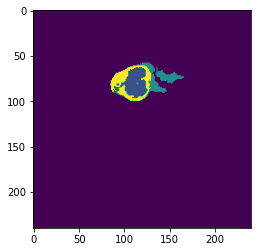

In [10]:
plt.imshow(img)

In [7]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_Flair = dset.ImageFolder(root=dataroot_Flair,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_T1 = dset.ImageFolder(root=dataroot_T1,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_T1c = dset.ImageFolder(root=dataroot_T1c,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_T2 = dset.ImageFolder(root=dataroot_T2,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT = dset.ImageFolder(root=dataroot_OT,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5), (0.5)),
                               to_tensor_4_chanel,
                               transforms.Normalize((0.5,0.5,0.5,0.5), (0.5,0.5,0.5,0.5)),
                           ]))
dataset_OT_Back = dset.ImageFolder(root=dataroot_OT_Back,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT_4ch = dset.ImageFolder(root=dataroot_OT_4ch,
                           loader = pil_loader_custome,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5,0.5), (0.5,0.5,0.5,0.5)),
                           ]))

dataset_OT_Back_test = dset.ImageFolder(root=dataroot_OT_Back_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_OT_test = dset.ImageFolder(root=dataroot_OT_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5), (0.5)),
                               to_tensor_4_chanel,
                               transforms.Normalize((0.5,0.5,0.5,0.5), (0.5,0.5,0.5,0.5)),
                           ]))
                               
dataset_OT_4ch_test = dset.ImageFolder(root=dataroot_OT_4ch_test,
                           loader = pil_loader_custome,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               to_tensor_4_chanel,
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5,0.5), (0.5,0.5,0.5,0.5)),
                           ]))

dataset_Flair_test = dset.ImageFolder(root=dataroot_Flair_test,
                           transform=transforms.Compose([ 
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_T1_test = dset.ImageFolder(root=dataroot_T1_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
                               
dataset_T1c_test = dset.ImageFolder(root=dataroot_T1c_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_T2_test = dset.ImageFolder(root=dataroot_T2_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size, interpolation=0),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [56]:
14 % 176 % 18

14

In [57]:
dataset_OT[133][0].shape

torch.Size([4, 64, 64])

In [8]:
ds =  CustomerDataset(dataset_Flair, dataset_T1, 
                      dataset_T1c, dataset_T2, 
                      dataset_OT, 
                      device=device, 
                      lstm_step=lstm_step_size)

In [9]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,pin_memory=False,timeout=0,
                                         shuffle=True, num_workers=workers)

In [13]:
ds[100][4].shape

torch.Size([40, 64, 64])

In [16]:
dataset_OT[100][0].shape

torch.Size([4, 64, 64])

In [10]:
colors = [(1,1,1),"#1f77b4", "#2ca02c", "k", "#d62728"] #w, blue, green , black, red
n_bin=5
cm = LinearSegmentedColormap.from_list(
            "", colors, N=n_bin)
def plt_color_segments(tsr, colors=colors, cm=cm, ch=4, values=(40,30,20,10), denoise=0.0):
      # R -> G -> B, Yellow
      # Discretizes the interpolation into bins 
    if ch == 4:
        image = tsr.view(-1,4,64,64)
        image -= denoise
        image[image > 0] = 1
        image[image <= 0] = 0
        screen = torch.zeros((image.shape[0],image.shape[2],image.shape[3]))
        
        ch3 = image[:,2,:,:]
        screen[ch3 > 0] = values[2] #green
        ch4 = image[:,3,:,:]
        screen[ch4 > 0] = values[3] #red
        ch2 = image[:,1,:,:]
        screen[ch2 > 0] = values[1] #blue
        ch1 = image[:,0,:,:]
        screen[ch1 > 0] = values[0] #black
        
        screen[:,0,0] = 40
        screen[:,0,1] = 30
        screen[:,0,2] = 20
        screen[:,0,3] = 10
        
        print(ch1.max(),ch2.max(),ch3.max(),ch4.max(), )
        print((ch1 > 0).sum(),(ch2 > 0).sum(), (ch3 > 0).sum(), (ch4 > 0).sum(), )
        #print(np.transpose(vutils.make_grid(screen.view(-1,1,64,64).cpu(), padding=2, normalize=True, nrow=5),(1,2,0)).shape)
        plt.imshow(np.transpose(vutils.make_grid(screen.view(-1,1,64,64).cpu(), padding=2, normalize=True, nrow=5),(1,2,0))[:,:,1], interpolation='nearest', origin='upper', cmap=cm)
    elif ch==1:
        image = tsr.view(-1,1,64,64)
        plt.imshow(np.transpose(vutils.make_grid(screen.view(-1,1,64,64).cpu(), padding=2, normalize=True, nrow=5),(1,2,0))[:,:,1], interpolation='nearest', origin='upper', cmap=cm)
    else:
        print("you need channel for 1 and 4")
        
    

tensor(1., device='cuda:0') tensor(1., device='cuda:0') tensor(1., device='cuda:0') tensor(1., device='cuda:0')
tensor(566, device='cuda:0') tensor(289, device='cuda:0') tensor(952, device='cuda:0') tensor(517, device='cuda:0')


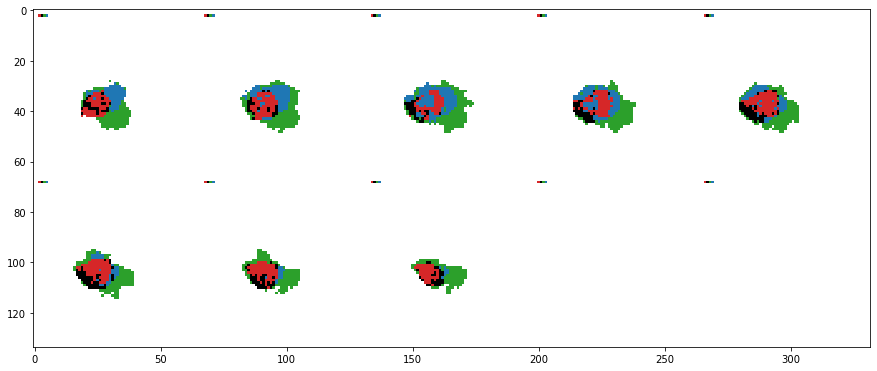

In [18]:
img = ds[100][4]
plt.figure(figsize=(15,10))
plt_color_segments(img)

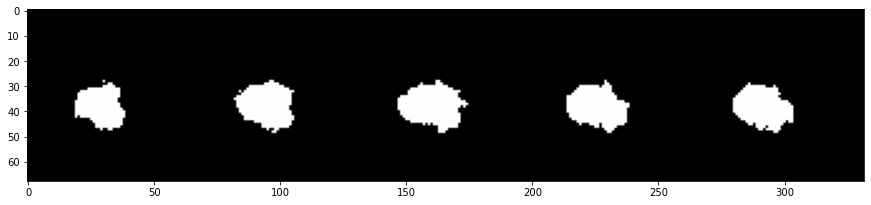

In [15]:
img = ds[100][4]
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(vutils.make_grid(img.view(-1,4, 64,64).sum(1).view(-1,1, 64,64).cpu(), padding=2, normalize=True, nrow=5),(1,2,0)))

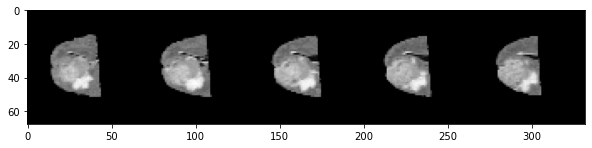

In [33]:
img = ds[100][0]
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(img.view(-1,1,64,64).cpu(), padding=2, normalize=True, nrow=5),(1,2,0)))

tensor(1., device='cuda:0') tensor(1., device='cuda:0') tensor(1., device='cuda:0') tensor(1., device='cuda:0')
tensor(366, device='cuda:0') tensor(169, device='cuda:0') tensor(635, device='cuda:0') tensor(462, device='cuda:0')


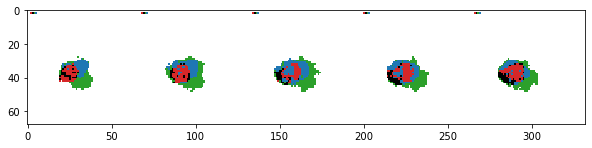

In [34]:
plt.figure(figsize=(10,10))
plt_color_segments(ds[100][4], ch=4)

In [35]:
len(ds)

3168

## Create the Model

In [11]:

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('LSTM') != -1:
        for name, weights in m.named_parameters():
            #print(name, weights )
            nn.init.normal_(weights, 0.5, 0.02) 

In [12]:
torch.zeros(1,1,100).to(device)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [13]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb, step_size, hidden_layer_size).to(device))
         

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size)) 
        return self.sigmoid(predictions)
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb, self.step_size, self.hidden_layer_size).to(device))

In [20]:
class Encoder(nn.Module):
    def __init__(self, ngpu, nc=nc, ndf=ndf, nz=nz):
        super(Encoder, self).__init__()
        self.ngpu = ngpu  
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, nz, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
         
        

    def forward(self, input):
        return self.main(input)

In [21]:

class Decoder(nn.Module):
    def __init__(self, ngpu, nc=nc, ndf=ndf, nz=nz):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# Create the Discriminator
netEncoder = Encoder(ngpu, nc=nc*4).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 300, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [23]:
# Create the Discriminator
netDecoder = Decoder(ngpu, nz=nz+lstm_output_size, nc=nc*4).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(600, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [24]:
model_LSTM = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, bidirectional=False).to(device)
loss_mse = nn.MSELoss() #ssim
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=lr)
model_LSTM.apply(weights_init)

NameError: name 'LSTM' is not defined

In [25]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Initialize BCELoss function
bceloss = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(fixed_noise_size, nz, 1, 1, device=device)

#  the progression of the generator
selected_index = np.random.randint(len(ds), size=fixed_noise_size)
fixed_ot_image = torch.stack([ds[i][0][1] for i in selected_index]).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerConvLSTM= optim.Adam(netConvLSTM.parameters(), lr=lr, betas=(beta1, 0.999))

## Prepare the Test set

In [11]:
ds_test =  CustomerDataset(dataset_Flair_test,
                           dataset_T1_test,
                           dataset_T1c_test,
                           dataset_T2_test, 
                           dataset_OT_test, 
                           device=device,
                           lstm_step=lstm_step_size, 
                           series_lenth=43 )


In [15]:
ds[3166][4].shape

torch.Size([40, 64, 64])

In [16]:
len(ds_test)

792

In [22]:
size_test = 5
selected_index = np.random.randint(len(dataset_Flair_test), size=size_test)
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[701 288 453 291 695]


# Experiments with Autoencoder(300 latent variable) + LSTM(300 output)

#### Training

In [23]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [24]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
#for epoch in range(1):
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        label_cpu = data_ot
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        model_LSTM.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)
        
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)

        #output = netConvLSTM(real_cpu) 
        output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size,1,1)), dim=1)).view(label_cpu.shape)
        #print("output.shape", output.shape)
        
        
        # Calculate loss on all-real batch 
        #err = mesloss(output, label_cpu)
        
        
        
        """
        output = output.view(-1, 4,  img_shape[2], img_shape[3])
        label_cpu = label_cpu.view(-1,4,  img_shape[2], img_shape[3])
        err_list = []
        for ch_idx in range(4):
            err_list.append(mesloss(output[:,ch_idx,:,:], 
                              label_cpu[:,ch_idx,:,:])) 
        err_list = sorted(err_list, key=lambda x:x.mean().item())
        for k, er in enumerate(err_list, 1):
            er *= 4**k 
            er.backward(retain_graph=True)
        err = np.mean([x.mean().item() for x in err_list]) 
        """
        
        err = mesloss(output, label_cpu) 
        
        # Calculate gradients for G
        err.backward()
        err = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizer_LSTM.step()
        optimizerEncoder.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), err))

        # Save Losses for plotting later
        losses.append(err)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1
        
print("Done")

Starting Training Loop...


NameError: name 'netEncoder' is not defined

#### Plot training result

NameError: name 'data_flair' is not defined

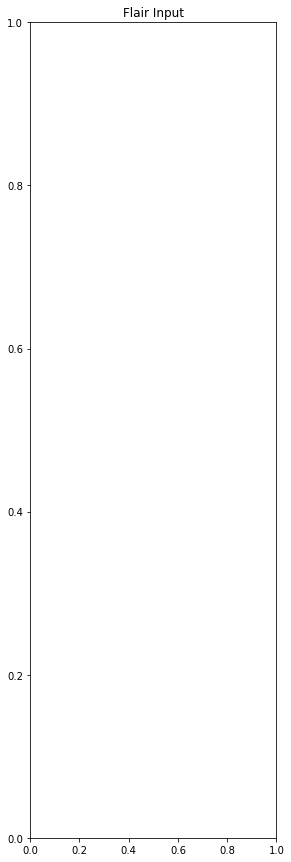

In [14]:
fig=plt.figure(figsize=(15,15))
fig.add_subplot(1, 3, 1)
plt.title("Flair Input") 
img = np.transpose(vutils.make_grid(data_flair.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 3, 2)
plt.title("Output")
plt_color_segments(output.view(-1, 4, 64, 64).detach().cpu())

fig.add_subplot(1, 3, 3)
plt.title("GroundTruth")
plt_color_segments(label_cpu.view(-1, 4, 64, 64).detach().cpu())
plt.show()

#### plot & save loss 

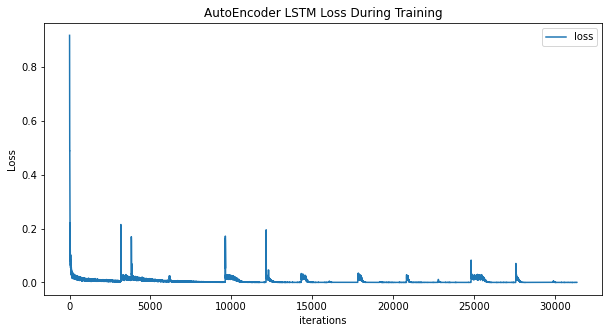

In [87]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder LSTM Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [70]:
with open("ae_lstm_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

#### Show the result on Testing set 

In [89]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


representation.shape torch.Size([5, 1500, 1, 1])
representation.view(size_test, -1, nz).shape torch.Size([5, 5, 300])
output_lstm.shape torch.Size([5, 5, 300])
torch.Size([5, 20, 64, 64])
output.shape torch.Size([5, 20, 64, 64])
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1023) tensor(330) tensor(2347) tensor(133)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1256) tensor(715) tensor(3160) tensor(676)


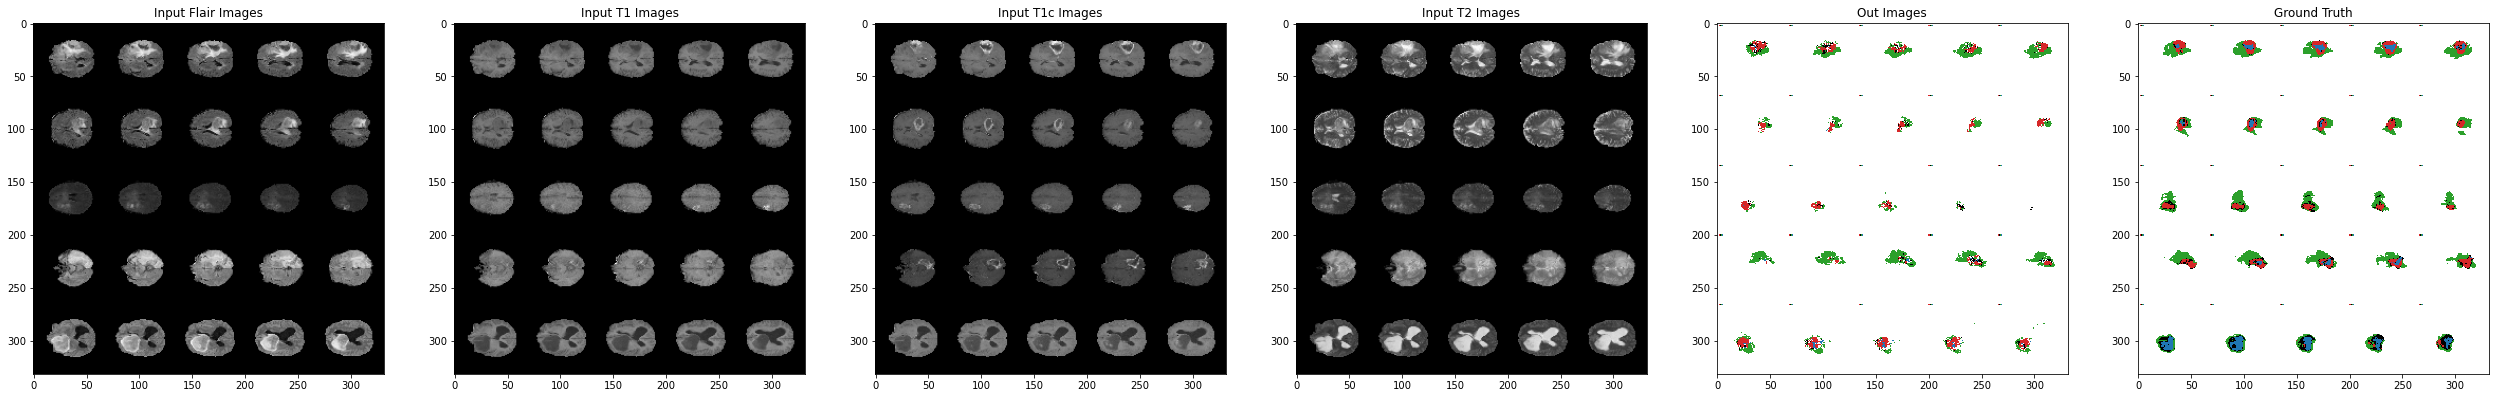

In [90]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
    #print(representation.shape)
    #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

    #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
    #                          model_LSTM.hidden_cell[1] * 0)
    
    print("representation.shape", representation.shape)
    print("representation.view(size_test, -1, nz).shape", representation.view(b_size, -1, nz).shape)
    output_lstm = model_LSTM(representation.view(b_size, -1, nz))
    print("output_lstm.shape", output_lstm.shape)

    #output = netConvLSTM(real_cpu) 
    print(fixed_OT_image.shape)
    output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size,1,1)), dim=1)).view(fixed_OT_image.shape)
    print("output.shape", output.shape)


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu(),values=(40,30,20,10))

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [91]:
output_list = [] 
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)

        #print("representation.shape", representation.shape)
        #print("representation.view(size_test, -1, nz).shape", representation.view(b_size, -1, nz).shape)
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)

        #output = netConvLSTM(real_cpu) 
        #print(fixed_OT_image.shape)
        output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size,1,1)), dim=1)).view(fixed_OT_image.shape)
        
        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [92]:
with open("ae_lstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [93]:
output.view(-1,4,64,64).shape

torch.Size([85, 4, 64, 64])

In [47]:
from monai.metrics import compute_meandice, compute_hausdorff_distance, DiceMetric

In [48]:
dice = DiceMetric()

In [96]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [97]:
output_list = [post_process(e) for e in output_list]

In [98]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [99]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.2356], device='cuda:0')
tensor([0.0595], device='cuda:0')
tensor([0.3318], device='cuda:0')
tensor([0.0425], device='cuda:0')


## Experience 1 Autoencoder with 600 latent variable

In [112]:
# Create the Discriminator
netEncoder = Encoder(ngpu, nz=nz*2, nc=nc*4).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 600, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [113]:
# Create the Discriminator
netDecoder = Decoder(ngpu, nz=nz*2, nc=nc*4).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(600, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [115]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Initialize BCELoss function
bceloss = torch.nn.BCELoss()
#ssim_loss = SSIM(window_size = 3)
 
# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerConvLSTM= optim.Adam(netConvLSTM.parameters(), lr=lr, betas=(beta1, 0.999))

In [116]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [131]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        netEncoder.zero_grad()
        netDecoder.zero_grad() 
        #output = netConvLSTM(real_cpu)  
        
        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
         
        output = netDecoder(representation.view(-1, nz*2,1,1)).view(mask_cpu.shape)
          
        # Calculate loss on all-real batch 
        err = mesloss(output.view(-1,4,  img_shape[2], img_shape[3]), mask_cpu.view(-1,4,  img_shape[2], img_shape[3]))  
         
        err.backward()
        err = err.mean().item() 
        
        """
        output = output.view(-1, 4,  img_shape[2], img_shape[3])
        mask_cpu = mask_cpu.view(-1,4,  img_shape[2], img_shape[3])
        err_list = []
        for ch_idx in range(4):
            err_list.append(mesloss(output[:,ch_idx,:,:], 
                              mask_cpu[:,ch_idx,:,:])) 
        err_list = sorted(err_list, key=lambda x:x.mean().item())
        for k, er in enumerate(err_list, 1):
            er *= 10**k 
            er.backward(retain_graph=True)
        err = np.mean([x.mean().item() for x in err_list]) 
        """
        # Update 
        optimizerDecoder.step() 
        optimizerEncoder.step() 
        #err.backward() 
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),   err))

        # Save Losses for plotting later
        losses.append(err)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 0.0006
[0/200][50/127]	Loss: 0.0004
[0/200][100/127]	Loss: 0.0005
[1/200][0/127]	Loss: 0.0004
[1/200][50/127]	Loss: 0.0005
[1/200][100/127]	Loss: 0.0004
[2/200][0/127]	Loss: 0.0003
[2/200][50/127]	Loss: 0.0004
[2/200][100/127]	Loss: 0.0004
[3/200][0/127]	Loss: 0.0005
[3/200][50/127]	Loss: 0.0003
[3/200][100/127]	Loss: 0.0004
[4/200][0/127]	Loss: 0.0005
[4/200][50/127]	Loss: 0.0009
[4/200][100/127]	Loss: 0.0004
[5/200][0/127]	Loss: 0.0005
[5/200][50/127]	Loss: 0.0159
[5/200][100/127]	Loss: 0.0226
[6/200][0/127]	Loss: 0.0209
[6/200][50/127]	Loss: 0.0220
[6/200][100/127]	Loss: 0.0158
[7/200][0/127]	Loss: 0.0163
[7/200][50/127]	Loss: 0.0187
[7/200][100/127]	Loss: 0.0269
[8/200][0/127]	Loss: 0.0199
[8/200][50/127]	Loss: 0.0171
[8/200][100/127]	Loss: 0.0240
[9/200][0/127]	Loss: 0.0219
[9/200][50/127]	Loss: 0.0192
[9/200][100/127]	Loss: 0.0183
[10/200][0/127]	Loss: 0.0191
[10/200][50/127]	Loss: 0.0234
[10/200][100/127]	Loss: 0.0173
[11/200][0/127

[91/200][50/127]	Loss: 0.0003
[91/200][100/127]	Loss: 0.0004
[92/200][0/127]	Loss: 0.0003
[92/200][50/127]	Loss: 0.0003
[92/200][100/127]	Loss: 0.0004
[93/200][0/127]	Loss: 0.0004
[93/200][50/127]	Loss: 0.0003
[93/200][100/127]	Loss: 0.0005
[94/200][0/127]	Loss: 0.0003
[94/200][50/127]	Loss: 0.0002
[94/200][100/127]	Loss: 0.0003
[95/200][0/127]	Loss: 0.0004
[95/200][50/127]	Loss: 0.0003
[95/200][100/127]	Loss: 0.0002
[96/200][0/127]	Loss: 0.0003
[96/200][50/127]	Loss: 0.0004
[96/200][100/127]	Loss: 0.0004
[97/200][0/127]	Loss: 0.0003
[97/200][50/127]	Loss: 0.0003
[97/200][100/127]	Loss: 0.0003
[98/200][0/127]	Loss: 0.0003
[98/200][50/127]	Loss: 0.0002
[98/200][100/127]	Loss: 0.0004
[99/200][0/127]	Loss: 0.0004
[99/200][50/127]	Loss: 0.0002
[99/200][100/127]	Loss: 0.0003
[100/200][0/127]	Loss: 0.0003
[100/200][50/127]	Loss: 0.0005
[100/200][100/127]	Loss: 0.0003
[101/200][0/127]	Loss: 0.0004
[101/200][50/127]	Loss: 0.0003
[101/200][100/127]	Loss: 0.0004
[102/200][0/127]	Loss: 0.0004
[10

KeyboardInterrupt: 

tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1711) tensor(901) tensor(6431) tensor(299)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1717) tensor(933) tensor(6503) tensor(311)


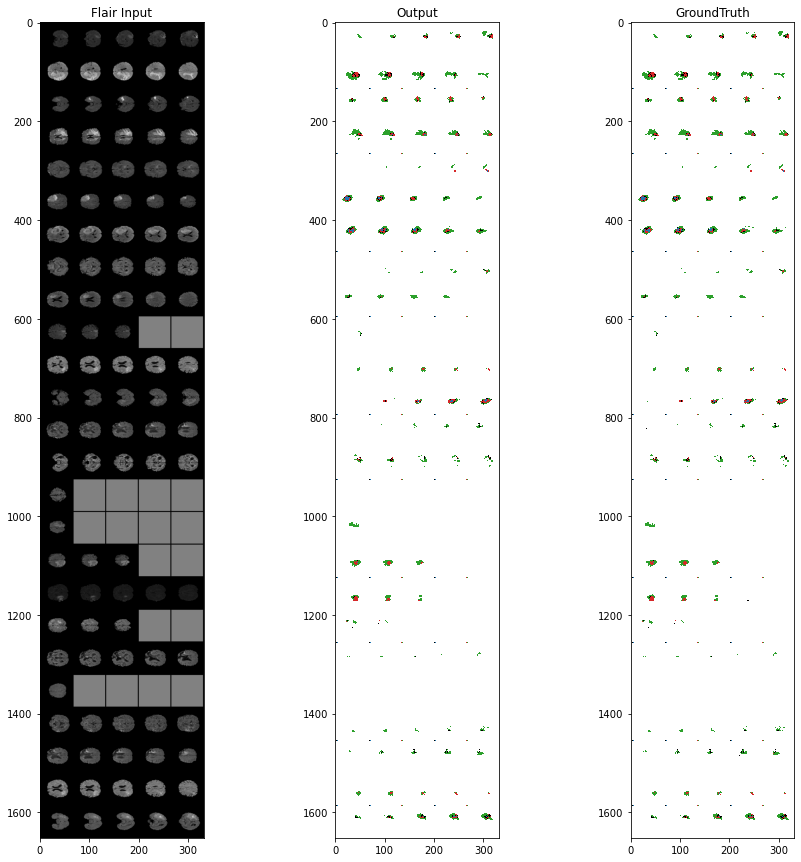

In [132]:
fig=plt.figure(figsize=(15,15))
fig.add_subplot(1, 3, 1)
plt.title("Flair Input") 
img = np.transpose(vutils.make_grid(data_flair.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 3, 2)
plt.title("Output")
plt_color_segments(output.view(-1, 4, 64, 64).detach().cpu(),values=(40,30,20,10), denoise=0.8)

fig.add_subplot(1, 3, 3)
plt.title("GroundTruth")
plt_color_segments(mask_cpu.view(-1, 4, 64, 64).detach().cpu())
plt.show()

In [484]:
with open("ae_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

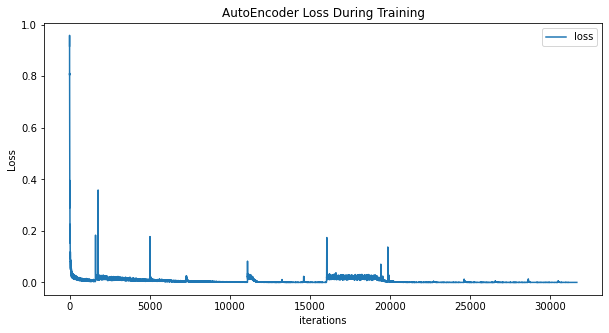

In [133]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [134]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(930) tensor(367) tensor(2353) tensor(189)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1256) tensor(715) tensor(3160) tensor(676)


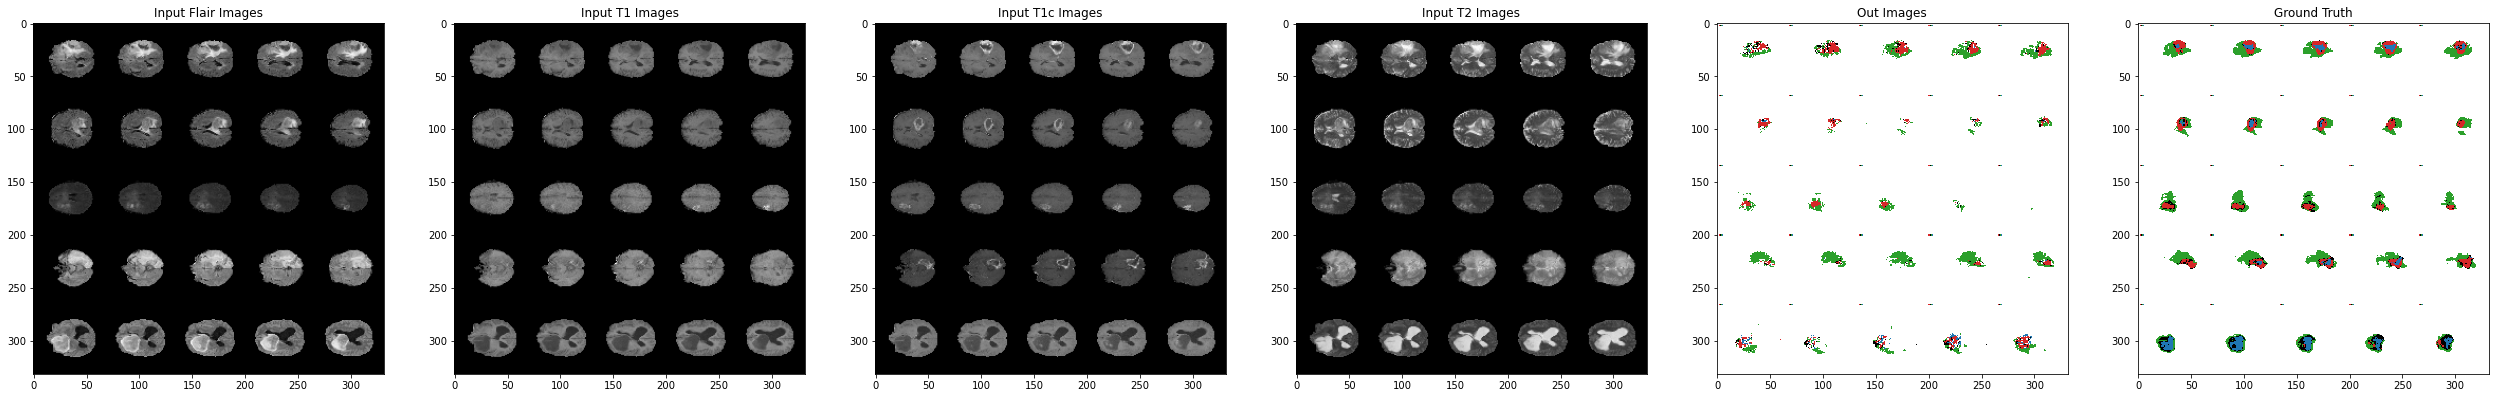

In [135]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1) 
    #print("output_lstm.shape", output_lstm.shape)
    #output = netDecoder(representation).view(real_cpu.shape)

    #output_lstm = model_LSTM(representation.view(size_test, -1, nz))
    
    output = netDecoder(representation.view(-1, nz*2,1,1)).view(ground_truth.shape)
    #print("output.shape", output.shape) 
    

    
# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu(), values=(40,30,20,10))

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
plt.show()

In [141]:
output_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
          
        output = netDecoder(representation.view(-1, nz*2,1,1)).view(fixed_OT_image.shape) 
        
        #print("output.shape", output.shape)
        output_list.append(output)
        

In [486]:
with open("ae_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [142]:
output.view(-1,4,64,64).shape

torch.Size([85, 4, 64, 64])

In [43]:
from monai.metrics import compute_meandice, compute_hausdorff_distance, DiceMetric

In [44]:
dice = DiceMetric()

In [144]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [145]:
output_list = [post_process(e) for e in output_list]

In [146]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [147]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.2394], device='cuda:0')
tensor([0.0684], device='cuda:0')
tensor([0.3170], device='cuda:0')
tensor([0.0599], device='cuda:0')


## Comparison with bi-directional lstm

In [28]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
            
        self.linear = nn.Linear(hidden_layer_size*self.num_directions, output_size)
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device))
        #self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print("lstm_out.shape", lstm_out.shape)
        #predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size * self.num_directions))
        #print("predictions.shape", predictions.shape)
        return self.sigmoid(lstm_out)
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device))

In [29]:
model_LSTM = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, bidirectional=True).to(device)
loss_mse = nn.MSELoss() #ssim
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=lr)
model_LSTM.apply(weights_init)

LSTM(
  (lstm): LSTM(300, 300, bidirectional=True)
  (linear): Linear(in_features=600, out_features=300, bias=True)
  (sigmoid): Sigmoid()
)

In [30]:
# Create the Discriminator
netEncoder = Encoder(ngpu, nc=4, nz=nz).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 300, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [31]:
# Create the Discriminator
netDecoder = Decoder(ngpu, nz=nz+lstm_output_size*2, nc=nc*4).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(900, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [32]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerConvLSTM= optim.Adam(netConvLSTM.parameters(), lr=lr, betas=(beta1, 0.999))

In [33]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [34]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        
        mask_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        model_LSTM.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3]))
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)
        
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))

        #output = netConvLSTM(real_cpu) 
        output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size*2,1,1)), dim=1)).view(mask_cpu.shape)
        #print("output.shape", output.shape)

        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizer_LSTM.step()
        optimizerEncoder.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 0.8267	D(x): 0.8267
[0/200][50/127]	Loss: 0.0818	D(x): 0.0818
[0/200][100/127]	Loss: 0.0201	D(x): 0.0201
[1/200][0/127]	Loss: 0.0130	D(x): 0.0130
[1/200][50/127]	Loss: 0.0173	D(x): 0.0173
[1/200][100/127]	Loss: 0.0203	D(x): 0.0203
[2/200][0/127]	Loss: 0.0110	D(x): 0.0110
[2/200][50/127]	Loss: 0.0234	D(x): 0.0234
[2/200][100/127]	Loss: 0.0131	D(x): 0.0131
[3/200][0/127]	Loss: 0.0149	D(x): 0.0149
[3/200][50/127]	Loss: 0.0133	D(x): 0.0133
[3/200][100/127]	Loss: 0.0169	D(x): 0.0169
[4/200][0/127]	Loss: 0.0075	D(x): 0.0075
[4/200][50/127]	Loss: 0.0079	D(x): 0.0079
[4/200][100/127]	Loss: 0.0108	D(x): 0.0108
[5/200][0/127]	Loss: 0.0080	D(x): 0.0080
[5/200][50/127]	Loss: 0.0124	D(x): 0.0124
[5/200][100/127]	Loss: 0.0071	D(x): 0.0071
[6/200][0/127]	Loss: 0.0113	D(x): 0.0113
[6/200][50/127]	Loss: 0.0210	D(x): 0.0210
[6/200][100/127]	Loss: 0.0262	D(x): 0.0262
[7/200][0/127]	Loss: 0.0121	D(x): 0.0121
[7/200][50/127]	Loss: 0.0117	D(x): 0.0117
[7/200][1

[63/200][100/127]	Loss: 0.0036	D(x): 0.0036
[64/200][0/127]	Loss: 0.0047	D(x): 0.0047
[64/200][50/127]	Loss: 0.0036	D(x): 0.0036
[64/200][100/127]	Loss: 0.0038	D(x): 0.0038
[65/200][0/127]	Loss: 0.0033	D(x): 0.0033
[65/200][50/127]	Loss: 0.0047	D(x): 0.0047
[65/200][100/127]	Loss: 0.0040	D(x): 0.0040
[66/200][0/127]	Loss: 0.0033	D(x): 0.0033
[66/200][50/127]	Loss: 0.0046	D(x): 0.0046
[66/200][100/127]	Loss: 0.0041	D(x): 0.0041
[67/200][0/127]	Loss: 0.0029	D(x): 0.0029
[67/200][50/127]	Loss: 0.0024	D(x): 0.0024
[67/200][100/127]	Loss: 0.0030	D(x): 0.0030
[68/200][0/127]	Loss: 0.0044	D(x): 0.0044
[68/200][50/127]	Loss: 0.0030	D(x): 0.0030
[68/200][100/127]	Loss: 0.0047	D(x): 0.0047
[69/200][0/127]	Loss: 0.0034	D(x): 0.0034
[69/200][50/127]	Loss: 0.0037	D(x): 0.0037
[69/200][100/127]	Loss: 0.0025	D(x): 0.0025
[70/200][0/127]	Loss: 0.0023	D(x): 0.0023
[70/200][50/127]	Loss: 0.0035	D(x): 0.0035
[70/200][100/127]	Loss: 0.0037	D(x): 0.0037
[71/200][0/127]	Loss: 0.0025	D(x): 0.0025
[71/200][50

[126/200][100/127]	Loss: 0.0004	D(x): 0.0004
[127/200][0/127]	Loss: 0.0005	D(x): 0.0005
[127/200][50/127]	Loss: 0.0004	D(x): 0.0004
[127/200][100/127]	Loss: 0.0006	D(x): 0.0006
[128/200][0/127]	Loss: 0.0005	D(x): 0.0005
[128/200][50/127]	Loss: 0.0004	D(x): 0.0004
[128/200][100/127]	Loss: 0.0004	D(x): 0.0004
[129/200][0/127]	Loss: 0.0005	D(x): 0.0005
[129/200][50/127]	Loss: 0.0003	D(x): 0.0003
[129/200][100/127]	Loss: 0.0005	D(x): 0.0005
[130/200][0/127]	Loss: 0.0003	D(x): 0.0003
[130/200][50/127]	Loss: 0.0004	D(x): 0.0004
[130/200][100/127]	Loss: 0.0003	D(x): 0.0003
[131/200][0/127]	Loss: 0.0004	D(x): 0.0004
[131/200][50/127]	Loss: 0.0003	D(x): 0.0003
[131/200][100/127]	Loss: 0.0004	D(x): 0.0004
[132/200][0/127]	Loss: 0.0006	D(x): 0.0006
[132/200][50/127]	Loss: 0.0042	D(x): 0.0042
[132/200][100/127]	Loss: 0.0015	D(x): 0.0015
[133/200][0/127]	Loss: 0.0007	D(x): 0.0007
[133/200][50/127]	Loss: 0.0005	D(x): 0.0005
[133/200][100/127]	Loss: 0.0003	D(x): 0.0003
[134/200][0/127]	Loss: 0.0005	D

[189/200][0/127]	Loss: 0.0003	D(x): 0.0003
[189/200][50/127]	Loss: 0.0006	D(x): 0.0006
[189/200][100/127]	Loss: 0.0006	D(x): 0.0006
[190/200][0/127]	Loss: 0.0006	D(x): 0.0006
[190/200][50/127]	Loss: 0.0005	D(x): 0.0005
[190/200][100/127]	Loss: 0.0004	D(x): 0.0004
[191/200][0/127]	Loss: 0.0004	D(x): 0.0004
[191/200][50/127]	Loss: 0.0003	D(x): 0.0003
[191/200][100/127]	Loss: 0.0005	D(x): 0.0005
[192/200][0/127]	Loss: 0.0003	D(x): 0.0003
[192/200][50/127]	Loss: 0.0004	D(x): 0.0004
[192/200][100/127]	Loss: 0.0003	D(x): 0.0003
[193/200][0/127]	Loss: 0.0004	D(x): 0.0004
[193/200][50/127]	Loss: 0.0006	D(x): 0.0006
[193/200][100/127]	Loss: 0.0003	D(x): 0.0003
[194/200][0/127]	Loss: 0.0003	D(x): 0.0003
[194/200][50/127]	Loss: 0.0003	D(x): 0.0003
[194/200][100/127]	Loss: 0.0002	D(x): 0.0002
[195/200][0/127]	Loss: 0.0003	D(x): 0.0003
[195/200][50/127]	Loss: 0.0004	D(x): 0.0004
[195/200][100/127]	Loss: 0.0003	D(x): 0.0003
[196/200][0/127]	Loss: 0.0003	D(x): 0.0003
[196/200][50/127]	Loss: 0.0003	D(

In [ ]:
with open("ae_bilstm_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

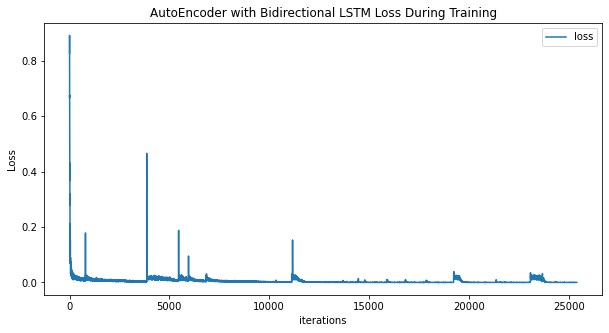

In [35]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder with Bidirectional LSTM Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


representation.shape torch.Size([5, 3000, 1, 1])
representation.view(size_test, -1, nz).shape torch.Size([5, 10, 300])
output_lstm.shape torch.Size([5, 10, 600])
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(2476) tensor(3750) tensor(4706) tensor(2112)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1562) tensor(893) tensor(5029) tensor(764)


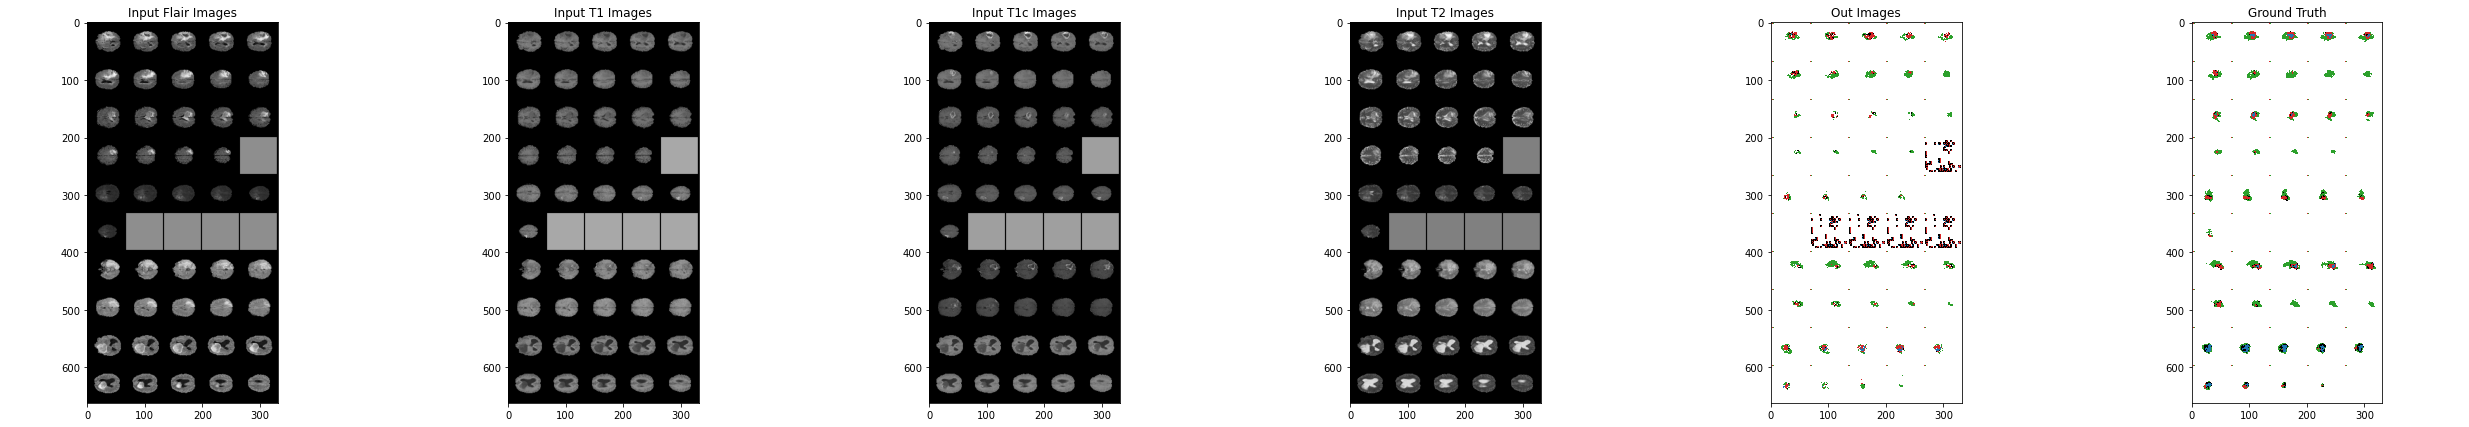

In [37]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
    #print(representation.shape)
    #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

    #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
    #                          model_LSTM.hidden_cell[1] * 0)
    
    print("representation.shape", representation.shape)
    print("representation.view(size_test, -1, nz).shape", representation.view(b_size, -1, nz).shape)
    output_lstm = model_LSTM(representation.view(b_size, -1, nz))
    print("output_lstm.shape", output_lstm.shape)

    #output = netConvLSTM(real_cpu) 
    output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size*2,1,1)), dim=1)).view(real_cpu.shape)
    #print("output.shape", output.shape)


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [38]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

        representation = netEncoder(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(b_size, -1, 1, 1)
        #print(representation.shape)
        #print("representation.view(b_size, -1, nz).shape", representation.view(b_size, -1, nz).shape)

        #model_LSTM.hidden_cell = (model_LSTM.hidden_cell[0] * 0, 
        #                          model_LSTM.hidden_cell[1] * 0)

        #print("representation.shape", representation.shape)
        #print("representation.view(size_test, -1, nz).shape", representation.view(b_size, -1, nz).shape)
        output_lstm = model_LSTM(representation.view(b_size, -1, nz))
        #print("output_lstm.shape", output_lstm.shape)

        #output = netConvLSTM(real_cpu) 
        #print(fixed_OT_image.shape)
        output = netDecoder(torch.cat((representation.view(-1, nz,1,1), output_lstm.view(-1, lstm_output_size*2,1,1)), dim=1)).view(fixed_OT_image.shape)
        
        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)

In [189]:
with open("ae_bilstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [190]:
with open("ground_truth.pkl", "wb") as f:
    pkl.dump(ground_truth_list, f)

In [39]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [40]:
output_list = [post_process(e) for e in output_list]

In [41]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [45]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.2017], device='cuda:0')
tensor([0.0607], device='cuda:0')
tensor([0.3492], device='cuda:0')
tensor([0.0416], device='cuda:0')


## Comparison with Unet + lstm

In [25]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.input_size = input_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
            
        self.linear = nn.Linear(hidden_layer_size*self.num_directions, output_size)
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device))
        #self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        if len(input_seq.shape) == 4:
            input_seq = input_seq.view(-1,self.step_size,self.input_size)
        print("input_seq.shape", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print("lstm_out.shape", lstm_out.shape)
        #predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size * self.num_directions))
        #print("predictions.shape", predictions.shape)
        return self.sigmoid(lstm_out)
        #return self.sigmoid(predictions)
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device))

In [379]:

from monai.networks.nets import UNet

In [407]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1) -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            mdl_down, lstm, model_up = self.submodule
            mdl_down_x = mdl_down(x)
            lstm_x = lstm(mdl_down_x)
            lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
            #print("mdl_down_x", mdl_down_x.shape )
            #print("lstm_x", lstm_x.shape )
            #res_x =  model_up(torch.cat([mdl_down_x, lstm_x], self.cat_dim))  
            res_x =  model_up(lstm_x)  
            #print("res1", res_x.shape )
            return res_x
        else:
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([x, self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.paddings = paddings
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1] + lstm_output_size
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d(upc_bottom, c + channels[1], 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c + channels[1], eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                ) 
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + channels[1]
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )

    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )  
        if is_top:
             conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [408]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

UNet(
  (lstm): LSTM(
    (lstm): LSTM(300, 300, bidirectional=True)
    (linear): Linear(in_features=600, out_features=300, bias=True)
    (sigmoid): Sigmoid()
  )
  (bottom_down): Convolution(
    (conv): Conv2d(512, 300, kernel_size=(4, 4), stride=(1, 1))
    (norm): InstanceNorm2d(300, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act): PReLU(num_parameters=1)
  )
  (bottom_up): Sequential(
    (0): ConvTranspose2d(600, 812, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(812, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
  )
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act): PReLU(num_parameters=1)
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv

In [409]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [ ]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 0.0008	D(x): 0.0008
[0/200][50/127]	Loss: 0.0006	D(x): 0.0006
[0/200][100/127]	Loss: 0.0010	D(x): 0.0010
[1/200][0/127]	Loss: 0.0005	D(x): 0.0005
[1/200][50/127]	Loss: 0.0005	D(x): 0.0005
[1/200][100/127]	Loss: 0.0004	D(x): 0.0004
[2/200][0/127]	Loss: 0.0006	D(x): 0.0006
[2/200][50/127]	Loss: 0.0004	D(x): 0.0004
[2/200][100/127]	Loss: 0.0009	D(x): 0.0009
[3/200][0/127]	Loss: 0.0004	D(x): 0.0004
[3/200][50/127]	Loss: 0.0009	D(x): 0.0009
[3/200][100/127]	Loss: 0.0007	D(x): 0.0007
[4/200][0/127]	Loss: 0.0003	D(x): 0.0003


In [ ]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

In [1]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [427]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(0.)
tensor(1054) tensor(3401) tensor(305) tensor(0)
tensor(1.) tensor(1.) tensor(1.) tensor(0.)
tensor(1256) tensor(3875) tensor(676) tensor(0)


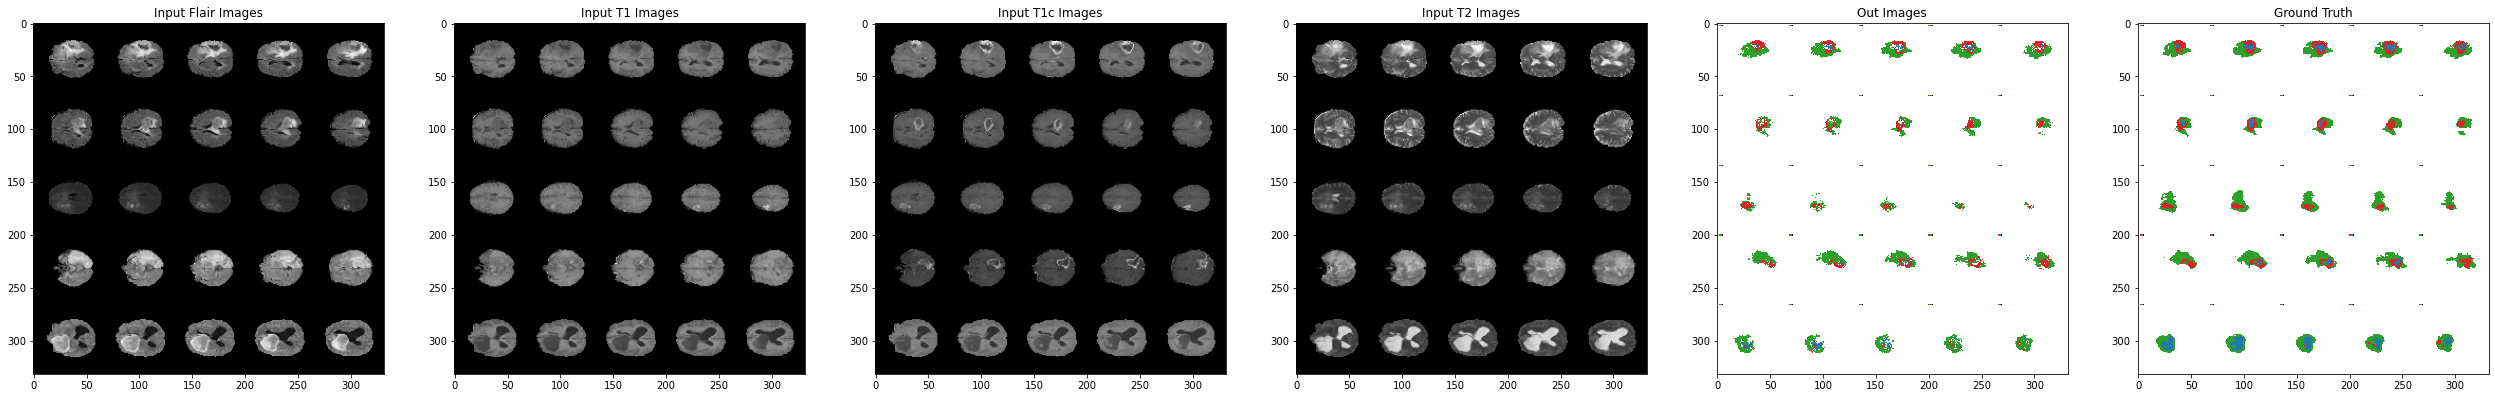

In [428]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [429]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [421]:
with open("Unet_lstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [422]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [430]:
output_list = [post_process(e) for e in output_list]

In [431]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [432]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5439], device='cuda:0')
tensor([0.4985], device='cuda:0')
tensor([0.2032], device='cuda:0')
tensor([0.], device='cuda:0')


In [350]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5402], device='cuda:0')
tensor([0.4879], device='cuda:0')
tensor([0.2026], device='cuda:0')
tensor([0.], device='cuda:0')


## Comparison with Unet

In [20]:

from monai.networks.nets import UNet

In [21]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1) -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            mdl_down, lstm, model_up = self.submodule
            mdl_down_x = mdl_down(x)
            #lstm_x = lstm(mdl_down_x)
            #lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
            #print("lstm_x", lstm_x.shape )
            #res_x =  model_up(torch.cat([mdl_down_x, lstm_x], self.cat_dim))  
            res_x =  model_up(torch.cat([mdl_down_x, mdl_down_x], self.cat_dim)) 
            #print("res1", res_x.shape )
            return res_x
        else:
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([x, self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.paddings = paddings
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1] * 2
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d( upc_bottom, c + channels[1], 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c + channels[1], eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                ) 
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + channels[1]
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )

    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )  
        if is_top:
             conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [22]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

NameError: name 'LSTM' is not defined

In [201]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [213]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward()  
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item()))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 0.0002
[0/200][50/127]	Loss: 0.0001
[0/200][100/127]	Loss: 0.0002
[1/200][0/127]	Loss: 0.0001
[1/200][50/127]	Loss: 0.0002
[1/200][100/127]	Loss: 0.0001
[2/200][0/127]	Loss: 0.0002
[2/200][50/127]	Loss: 0.0002
[2/200][100/127]	Loss: 0.0001
[3/200][0/127]	Loss: 0.0002
[3/200][50/127]	Loss: 0.0001
[3/200][100/127]	Loss: 0.0001
[4/200][0/127]	Loss: 0.0001
[4/200][50/127]	Loss: 0.0001
[4/200][100/127]	Loss: 0.0002
[5/200][0/127]	Loss: 0.0001
[5/200][50/127]	Loss: 0.0001
[5/200][100/127]	Loss: 0.0001
[6/200][0/127]	Loss: 0.0002
[6/200][50/127]	Loss: 0.0002
[6/200][100/127]	Loss: 0.0001
[7/200][0/127]	Loss: 0.0002
[7/200][50/127]	Loss: 0.0002
[7/200][100/127]	Loss: 0.0001
[8/200][0/127]	Loss: 0.0002
[8/200][50/127]	Loss: 0.0003
[8/200][100/127]	Loss: 0.0002
[9/200][0/127]	Loss: 0.0001
[9/200][50/127]	Loss: 0.0001
[9/200][100/127]	Loss: 0.0002
[10/200][0/127]	Loss: 0.0001
[10/200][50/127]	Loss: 0.0002
[10/200][100/127]	Loss: 0.0001
[11/200][0/127

KeyboardInterrupt: 

In [ ]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

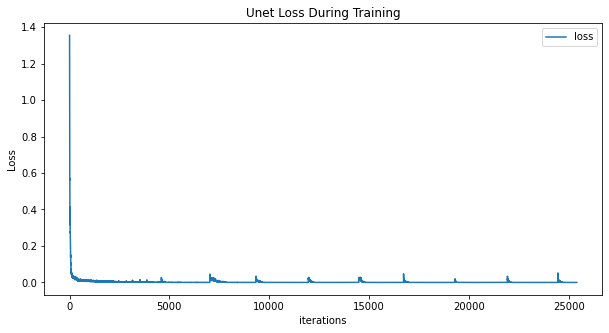

In [214]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [215]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1039) tensor(376) tensor(2875) tensor(427)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1256) tensor(715) tensor(3160) tensor(676)


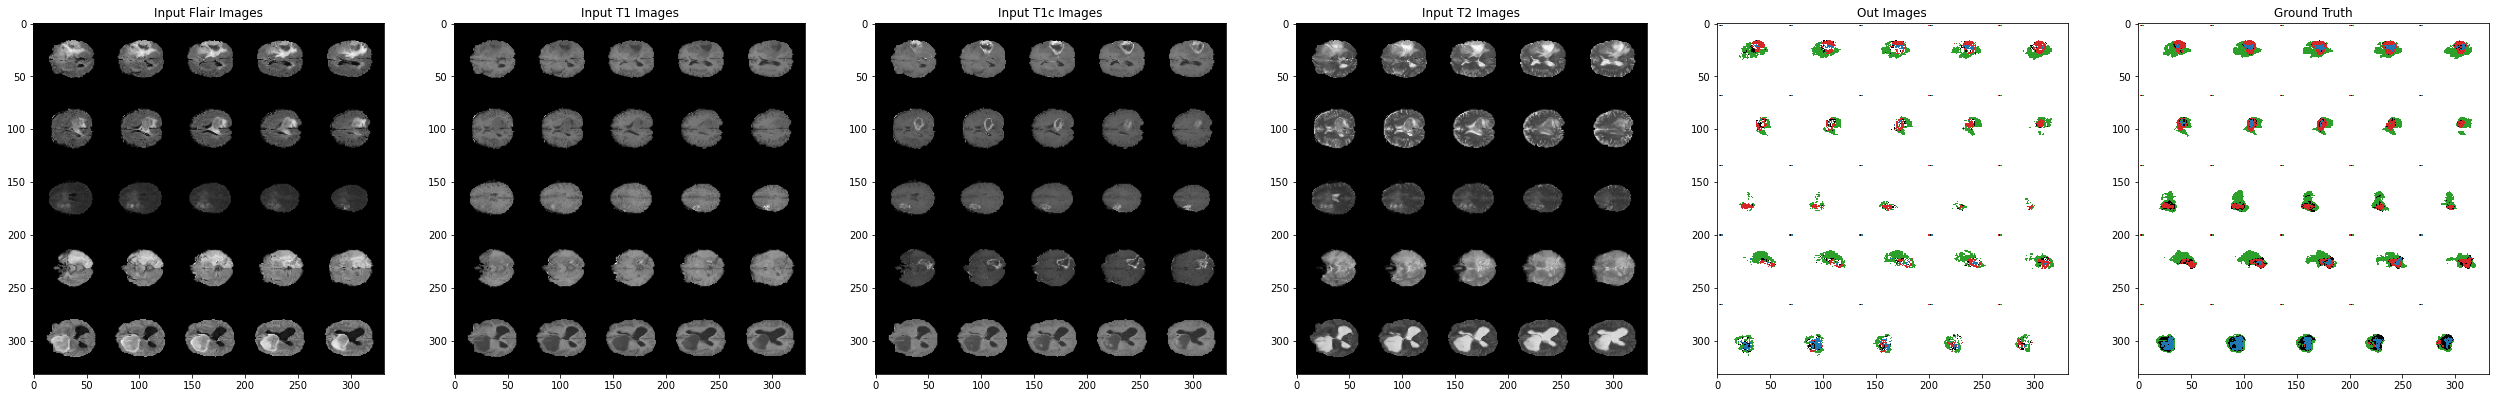

In [216]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [217]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [218]:
with open("Unet_lstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [219]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [220]:
output_list = [post_process(e) for e in output_list]

In [221]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [222]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5262], device='cuda:0')
tensor([0.0838], device='cuda:0')
tensor([0.4538], device='cuda:0')
tensor([0.2270], device='cuda:0')


In [212]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5300], device='cuda:0')
tensor([0.0746], device='cuda:0')
tensor([0.4434], device='cuda:0')
tensor([0.2171], device='cuda:0')


## Comparison with Unet

In [113]:

from monai.networks.nets import UNet

In [32]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1) -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            mdl_down, lstm, model_up = self.submodule
            mdl_down_x = mdl_down(x)
            #lstm_x = lstm(mdl_down_x)
            #lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
            #print("lstm_x", lstm_x.shape )
            #res_x =  model_up(torch.cat([mdl_down_x, lstm_x], self.cat_dim))  
            res_x =  model_up(torch.cat([mdl_down_x, mdl_down_x], self.cat_dim)) 
            #print("res1", res_x.shape )
            return res_x
        else:
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([x, self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.paddings = paddings
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1] * 2
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d( upc_bottom, c + channels[1], 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c + channels[1], eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                ) 
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + channels[1]
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )

    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )  
        if is_top:
             conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [33]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

UNet(
  (lstm): LSTM(
    (lstm): LSTM(300, 300, bidirectional=True)
    (linear): Linear(in_features=300, out_features=300, bias=True)
    (sigmoid): Sigmoid()
  )
  (bottom_down): Convolution(
    (conv): Conv2d(512, 300, kernel_size=(4, 4), stride=(1, 1))
    (norm): InstanceNorm2d(300, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act): PReLU(num_parameters=1)
  )
  (bottom_up): Sequential(
    (0): ConvTranspose2d(600, 812, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(812, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
  )
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act): PReLU(num_parameters=1)
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv

In [34]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [50]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 0.0003	D(x): 0.0003
[0/200][50/127]	Loss: 0.0002	D(x): 0.0002
[0/200][100/127]	Loss: 0.0001	D(x): 0.0001
[1/200][0/127]	Loss: 0.0002	D(x): 0.0002
[1/200][50/127]	Loss: 0.0002	D(x): 0.0002
[1/200][100/127]	Loss: 0.0002	D(x): 0.0002
[2/200][0/127]	Loss: 0.0001	D(x): 0.0001
[2/200][50/127]	Loss: 0.0002	D(x): 0.0002
[2/200][100/127]	Loss: 0.0001	D(x): 0.0001
[3/200][0/127]	Loss: 0.0002	D(x): 0.0002
[3/200][50/127]	Loss: 0.0002	D(x): 0.0002
[3/200][100/127]	Loss: 0.0002	D(x): 0.0002
[4/200][0/127]	Loss: 0.0002	D(x): 0.0002
[4/200][50/127]	Loss: 0.0002	D(x): 0.0002
[4/200][100/127]	Loss: 0.0002	D(x): 0.0002
[5/200][0/127]	Loss: 0.0001	D(x): 0.0001
[5/200][50/127]	Loss: 0.0002	D(x): 0.0002
[5/200][100/127]	Loss: 0.0001	D(x): 0.0001
[6/200][0/127]	Loss: 0.0002	D(x): 0.0002
[6/200][50/127]	Loss: 0.0001	D(x): 0.0001
[6/200][100/127]	Loss: 0.0002	D(x): 0.0002
[7/200][0/127]	Loss: 0.0002	D(x): 0.0002
[7/200][50/127]	Loss: 0.0003	D(x): 0.0003
[7/200][1

KeyboardInterrupt: 

In [ ]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

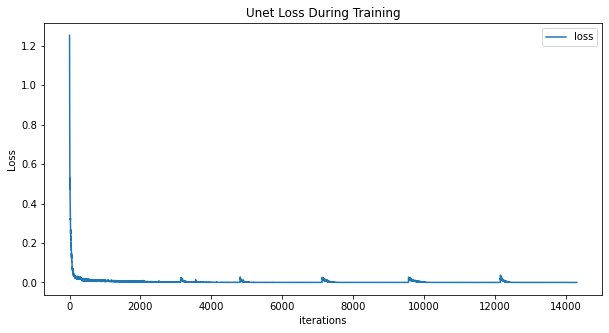

In [51]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(974) tensor(268) tensor(2643) tensor(476)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1256) tensor(715) tensor(3160) tensor(676)


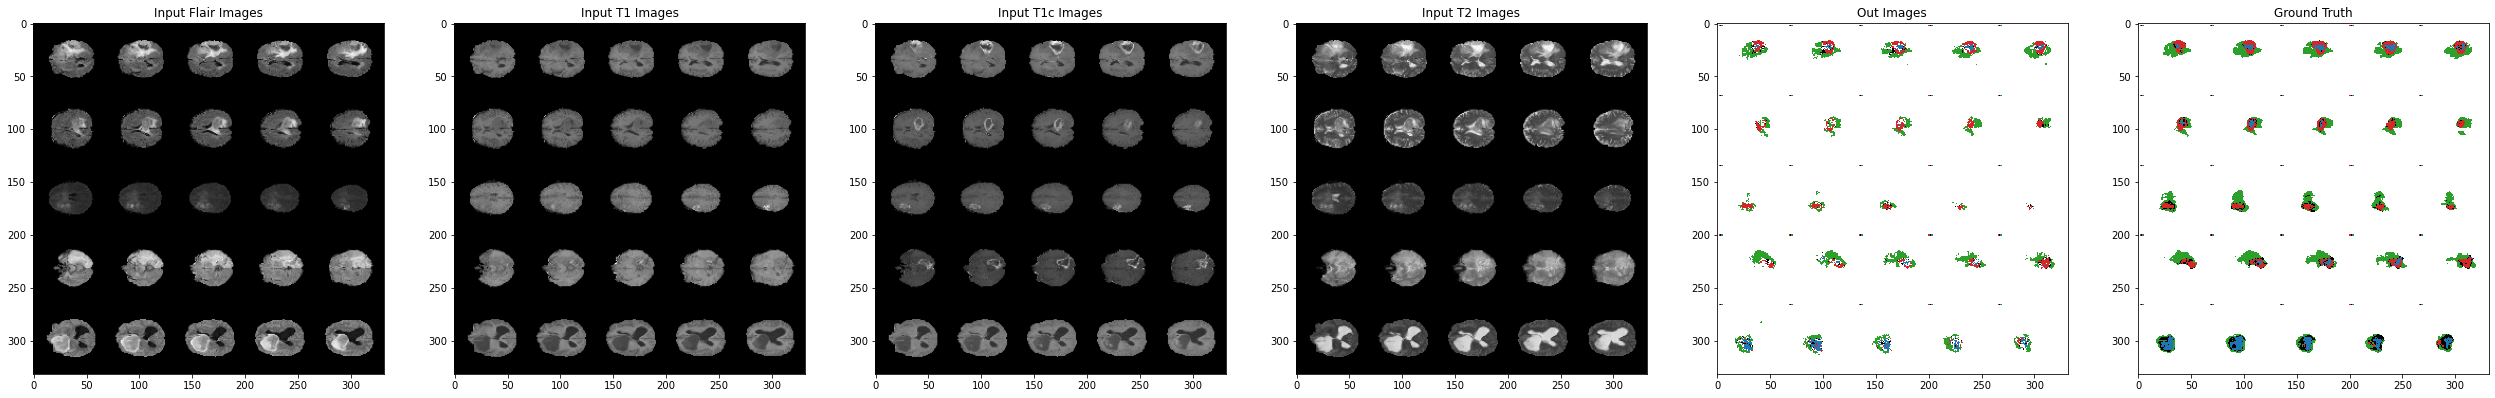

In [53]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [54]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [352]:
with open("Unet_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [55]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [56]:
from monai.metrics import compute_meandice, compute_hausdorff_distance, DiceMetric

In [57]:
dice = DiceMetric()

In [58]:
output_list = [post_process(e) for e in output_list]

In [59]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [60]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5229], device='cuda:0')
tensor([0.0710], device='cuda:0')
tensor([0.4536], device='cuda:0')
tensor([0.2174], device='cuda:0')


In [377]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5495], device='cuda:0')
tensor([0.5184], device='cuda:0')
tensor([0.2548], device='cuda:0')
tensor([0.], device='cuda:0')


## Unet with low level conv2d lstm  

In [113]:

from monai.networks.nets import UNet

In [61]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [290]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class Conv2DLSTM(nn.Module):
    def __init__(self, ch_in, 
                  ch_out, 
                  kernal_size_in,
                  kernal_size_out,
                  lstm_step_size,
                  hidden_layer_size,
                  lstm_input_size,
                  lstm_output_size,
                  ngpu=1,
                 ) -> None:
        super().__init__()
        self.conv2d_in = nn.Sequential(
                    nn.Conv2d(ch_in, ch_out, kernal_size_in, 2, (0,1), bias=False),
                    nn.BatchNorm2d(ch_out),
                    nn.LeakyReLU(0.2, inplace=True),
                    )
        self.conv2d_out = nn.Sequential( 
                    nn.ConvTranspose2d(ch_out, ch_in, kernal_size_out, 2, (0,1), bias=False),
                    nn.BatchNorm2d(ch_in),
                    nn.ReLU(True),
                    ) 
        self.lstm = LSTM(ngpu=ngpu, 
                         input_size=lstm_input_size, 
                         step_size=lstm_step_size, 
                         hidden_layer_size=hidden_layer_size, 
                         output_size=lstm_output_size, 
                         bidirectional=True)
        self.ch_in = ch_in
        self.lstm_step_size = lstm_step_size
        self.ch_out = ch_out
        self.lstm_input_size = lstm_input_size
        self.lstm_output_size = lstm_output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print("x.shape", x.shape)
        res = self.conv2d_in(x)
        print("res.shape", res.shape)
        res = self.lstm(res.view(-1, self.lstm_step_size, self.lstm_input_size))
        res = self.conv2d_out(res.view(-1, self.ch_in, self.ch_out))
        return res


class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1) -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            if len(self.submodule) == 3:
                mdl_down, lstm, model_up = self.submodule
                mdl_down_x = mdl_down(x)
                #lstm_x = lstm(mdl_down_x)
                #lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
                #print("lstm_x", lstm_x.shape )
                #res_x =  model_up(torch.cat([mdl_down_x, lstm_x], self.cat_dim))  
                res_x =  model_up(torch.cat([mdl_down_x, mdl_down_x], self.cat_dim)) 
                #print("res1", res_x.shape )
                return res_x
            elif len(self.submodule) == 2:
                sub_blk, con2d_lstm = self.submodule
                sub_blk_x = sub_blk(x)
                con2d_lstm_x = con2d_lstm(x)
                res_x =  model_up(torch.cat([x, sub_blk_x, con2d_lstm_x], self.cat_dim)) 
                return res_x
                
        else:
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([x, self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernels: Sequence[tuple],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.paddings = paddings
        self.kernels = kernels
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int],
            kernels: Sequence[tuple], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]
            kns = kernels[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:],kernels[1:], False).to(device)  # continue recursion down
                ConvLSTM()
                bridge_con2d_lstm = Conv2DLSTM(ch_in=c, ch_out=c, 
                                  kernal_size_in=kns, kernal_size_out=(kns[1],kns[0]),
                                  lstm_step_size=lstm_step_size,
                                  hidden_layer_size=hidden_layer_size,
                                  lstm_input_size=kns[0],
                                  lstm_output_size=kns[0]).to(device)
                
                subblock = [subblock, bridge_con2d_lstm]
                upc = c * 2 + c
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1] * 2
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d( upc_bottom, c + channels[1], 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c + channels[1], eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                ) 
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + channels[1]
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, self.kernels, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )

    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )  
        if is_top:
             conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [294]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            kernels=[(64,4),(32,4),(16,4),(8,4),(4,4)],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 5.86 GiB already allocated; 998.40 KiB free; 5.88 GiB reserved in total by PyTorch)

In [292]:

# Lists to keep track of progress
img_list = [] 
losses = []

In [293]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 5.86 GiB already allocated; 998.40 KiB free; 5.88 GiB reserved in total by PyTorch)

In [ ]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

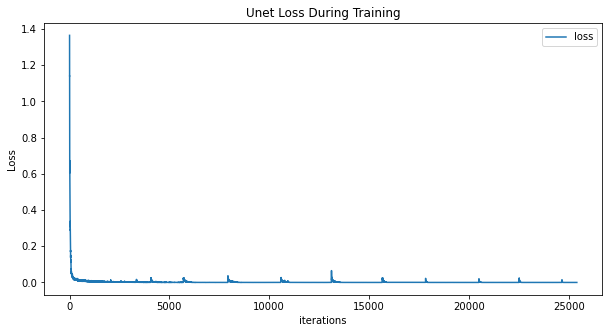

In [369]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [370]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(0.)
tensor(1021) tensor(3564) tensor(489) tensor(0)
tensor(1.) tensor(1.) tensor(1.) tensor(0.)
tensor(1256) tensor(3875) tensor(676) tensor(0)


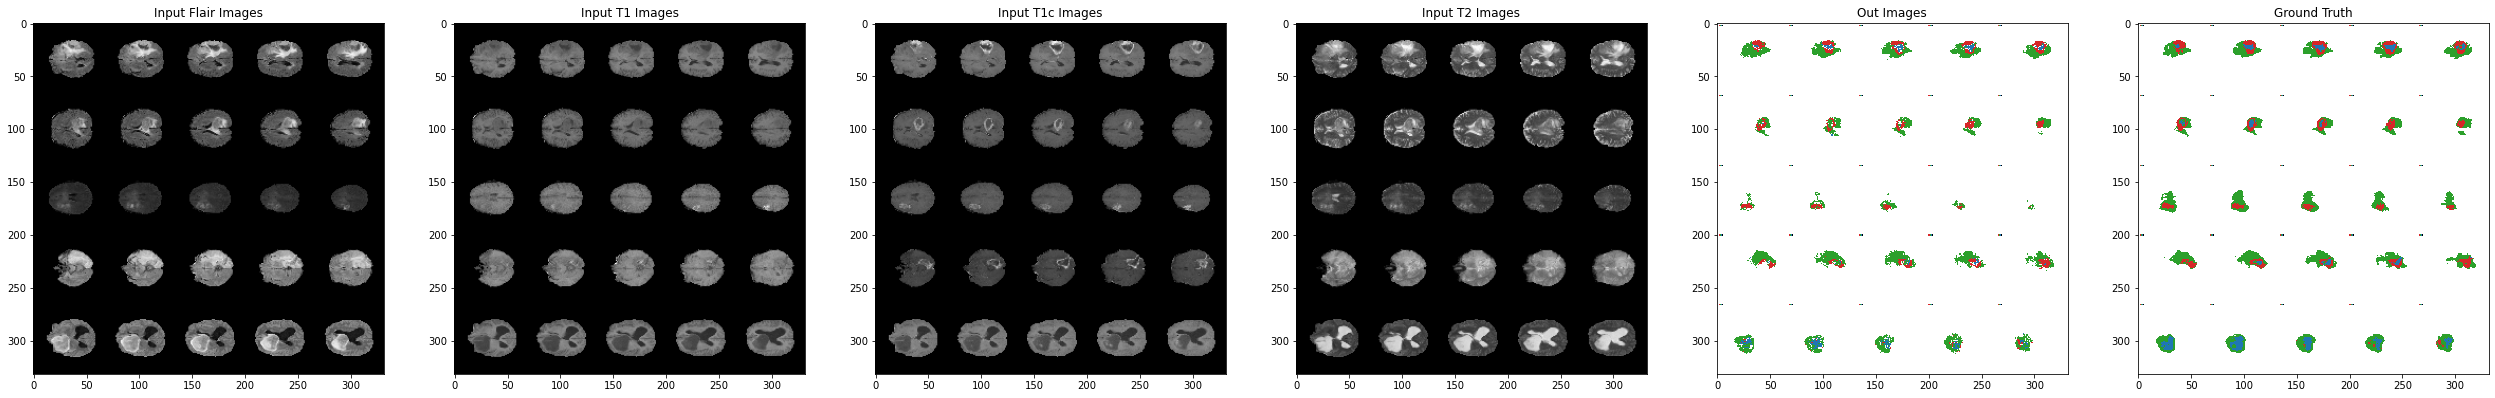

In [371]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [372]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [352]:
with open("Unet_lstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [373]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [374]:
output_list = [post_process(e) for e in output_list]

In [375]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [376]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5495], device='cuda:0')
tensor([0.5184], device='cuda:0')
tensor([0.2548], device='cuda:0')
tensor([0.], device='cuda:0')


In [377]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5495], device='cuda:0')
tensor([0.5184], device='cuda:0')
tensor([0.2548], device='cuda:0')
tensor([0.], device='cuda:0')


In [98]:
images_in = torch.rand((10,4,64,64)).to(device)
images_out = torch.rand((10,4,64,64)).to(device)

In [13]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
            
        self.linear = nn.Linear(hidden_layer_size*self.num_directions, output_size)
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device))
        #self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print("lstm_out.shape", lstm_out.shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size * self.num_directions))
        #print("predictions.shape", predictions.shape)
        return self.sigmoid(predictions)
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device))

In [14]:
class Conv2DLSTM(nn.Module):
    def __init__(self, ch_in, 
                  ch_out, 
                  kernal_size,
                  strides,
                  paddings,
                  lstm_step_size,
                  hidden_layer_size,
                  lstm_input_size,
                  lstm_output_size,
                  ngpu=1,
                 ) -> None:
        super().__init__()
        self.conv2d_in = nn.Sequential(
                    nn.Conv2d(ch_in, lstm_input_size, kernal_size, strides[0], paddings[0], bias=False),
                    nn.BatchNorm2d(lstm_input_size),
                    nn.LeakyReLU(0.2, inplace=True),
                    ).to(device)
        self.conv2d_out = nn.Sequential( 
                    nn.ConvTranspose2d(lstm_output_size, ch_in, kernal_size, strides[1], paddings[1], bias=False),
                    nn.BatchNorm2d(ch_in),
                    nn.ReLU(True),
                    ).to(device)
        self.lstm = LSTM(ngpu=ngpu, 
                         input_size=lstm_input_size, 
                         step_size=lstm_step_size, 
                         hidden_layer_size=hidden_layer_size, 
                         output_size=lstm_output_size, 
                         bidirectional=True).to(device)
        self.ch_in = ch_in
        self.lstm_step_size = lstm_step_size
        self.ch_out = ch_out
        self.lstm_input_size = lstm_input_size
        self.lstm_output_size = lstm_output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
            
        #print("x.shape", x.shape)
        res = self.conv2d_in(x)
       # print("res.shape", res.shape)
        conv_shape = res.shape
        if x.shape[0] == self.lstm_step_size:
            res = np.transpose(res.cpu().detach(), (2,3,0,1)).to(device)
            res = torch.transpose(res, 0,2) 
            res = torch.transpose(res, 1,3) 
        elif x.shape[0] > self.lstm_step_size: 
            res = res.view(-1, self.lstm_step_size, res.shape[1], res.shape[2],res.shape[3])
            res = torch.transpose(res, 1,3) 
            res = torch.transpose(res, 2,4) 
            
        shape = res.shape
        #print("transpose res.shape", res.shape)
        res = res.reshape(-1, shape[2], self.lstm_step_size, self.lstm_input_size)
        res = self.lstm(res.reshape(-1, self.lstm_step_size, self.lstm_input_size))
       # print("res.shape", res.shape)
        res = res.view(shape)
       # print("res.view shape", res.shape)

        if x.shape[0] == self.lstm_step_size:
            #res = torch.transpose(res, (2,3,0,1)) 
            res = torch.transpose(res, 0,2) 
            res = torch.transpose(res, 1,3) 
        elif x.shape[1] > self.lstm_step_size:
            #res = torch.transpose(res, (0,3,4,1,2)) 
            res = torch.transpose(res, 1,3) 
            res = torch.transpose(res, 2,4) 
             
       # print("res.transpose shape.view(shape)", res.shape)
        res = res.reshape(conv_shape) 
       # print("res.shape.view(x.shape)", res.shape)
        
        res = self.conv2d_out(res)
        return res


In [22]:
class Conv2DLSTM2(nn.Module):
    def __init__(self, ch_in, 
                  ch_out, 
                  kernal_size,
                  strides,
                  paddings,
                  lstm_step_size,
                  hidden_layer_size,
                  lstm_input_size,
                  lstm_output_size,
                  ngpu=1,
                 ) -> None:
        super().__init__()
        self.conv2dlstm_1 = Conv2DLSTM(ch_in, 
                  ch_out, 
                  kernal_size,
                  strides,
                  paddings,
                  lstm_step_size,
                  hidden_layer_size,
                  lstm_input_size,
                  lstm_output_size,
                  ngpu=1,).to(device)
        self.conv2dlstm_2 = Conv2DLSTM(ch_in, 
                  ch_out, 
                  kernal_size,
                  strides,
                  paddings,
                  lstm_step_size,
                  hidden_layer_size,
                  lstm_input_size,
                  lstm_output_size,
                  ngpu=1,).to(device)
        
        self.conv2d_1 = nn.ConvTranspose2d(ch_in, 
                  ch_out, 
                  (3,3),
                  (1,1),
                  (1,1),   bias=False ).to(device)
        self.conv2d_2 = nn.ConvTranspose2d(ch_in, 
                  ch_out, 
                  (3,3),
                  (1,1),
                  (1,1),   bias=False ).to(device)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: 

        res_1 = self.conv2dlstm_1(x)
        #print(res_1.shape)
        res_2 = self.conv2dlstm_2(x)
        #print(res_2.shape)
        return self.conv2d_1(res_1 * res_2)

In [17]:
conv2dlstm = Conv2DLSTM(ch_in=4, 
                  ch_out=4, 
                  kernal_size=(64,4),
                  strides=[2,2],
                  paddings=[(0,1), (0,1)],
                  lstm_step_size=10,
                  hidden_layer_size=32 * 4,
                  lstm_input_size=32 * 4,
                  lstm_output_size=32 * 4,
                  ngpu=1,).to(device)

In [376]:
res = conv2dlstm(images_in)
print(res.shape)

x.shape torch.Size([10, 4, 32, 32])


RuntimeError: Calculated padded input size per channel: (32 x 34). Kernel size: (64 x 4). Kernel size can't be greater than actual input size

In [18]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.ConvTranspose2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [19]:
channels=4
model = ConvLSTM(input_dim=channels,
                 hidden_dim=[10,4],
                 kernel_size=(5, 5),
                 num_layers=2,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)

In [20]:
print(model)

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): ConvTranspose2d(14, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): ConvTranspose2d(14, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)


In [21]:
images_in = torch.rand((25,10,4,64,64)).to(device)
images_out = torch.rand((25,10,4,64,64)).to(device)

In [22]:
loss = nn.MSELoss() 
optimizer= optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))


In [23]:
for i in range(100):
    input_image = images_in
    label_image = images_out
    model.zero_grad()
    
    output_image, _ = model(input_image)
    print([i.shape for i in output_image])
    print([len(i) for i in _])
    for i in _:
        for j in i:
            print(j.shape)
    err = loss(output_image[0], label_image)
    print(err.mean().item())
    err.backward()
    
    optimizer.step()
    

[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.32422614097595215
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.32198572158813477
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.3195022642612457
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.31668898463249207
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.31343209743499756
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.3095787465572357
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.30492064356803894
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.29917189478874207
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 6

[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09992190450429916
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09960660338401794
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09929817914962769
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09899638593196869
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09870100766420364
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09841182082891464
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09812865406274796
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64, 64])
0.09785130620002747
[torch.Size([25, 10, 4, 64, 64])]
[2]
torch.Size([25, 4, 64, 64])
torch.Size([25, 4, 64,

In [24]:
data_flair,data_t1,data_t1c,data_t2, data_ot = next(iter(dataloader))
img_shape = data_flair.shape
real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                      data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                      data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                      data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                      ), dim=2).view(batch_size, -1, 4, img_shape[2], img_shape[3])
mask_cpu = data_ot.view(batch_size, -1, 4, img_shape[2], img_shape[3])  
    

In [25]:
torch.cuda.empty_cache()

In [45]:
channels=4
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = ConvLSTM(input_dim=channels,
                     hidden_dim=[10, 4],
                     kernel_size=(5, 5),
                     num_layers=2,
                     batch_first=True,
                     bias=True,
                     return_all_layers=False).to(device)

        self.trans = nn.Sequential(
                    # state size. (ngf) x 32 x 32
                    nn.ConvTranspose2d( 20, 4, 5, 1, 2, bias=False),
                    nn.Tanh() 
                    )
    def forward(self, x):
        x_shape = x.shape
        res,_ = self.model(x)
        #res = res[0].view(-1,20,x_shape[3],x_shape[4])
        #res = self.trans(res)
        #return res.view(x_shape)
        return res[0]
        

In [46]:
model = MyModel().to(device)
loss = nn.MSELoss() 
#small_test.apply(weights_init)
optimizer= optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999)) 


In [47]:
for i in range(1000):
    input_image = mask_cpu
    label_image = mask_cpu
    
    #print(label_image.shape)
    model.zero_grad()
    
    output_image = model(input_image)
    #print([i.shape for i in output_image])
    #print([len(i) for i in _])
    #for i in _:
    #    for j in i:
            #print(j.shape)
    err = loss(output_image, label_image)
    print(err.mean().item())
    err.backward()
    
    optimizer.step()
    

0.6749283671379089
0.6691272258758545
0.662233293056488
0.6538500189781189
0.643414318561554
0.630142331123352
0.6130561828613281
0.5910843014717102
0.563387930393219
0.5301542282104492
0.4935675263404846
0.45755860209465027
0.4256700575351715
0.3994019329547882
0.3785197138786316
0.36189186573028564
0.3480868637561798
0.33589527010917664
0.32457587122917175
0.313784122467041
0.303397536277771
0.29338011145591736
0.283713161945343
0.27437418699264526
0.26533764600753784
0.25658097863197327
0.24808774888515472
0.23984767496585846
0.23185501992702484
0.22410669922828674
0.2166009247303009
0.20933642983436584
0.202311709523201
0.19552499055862427
0.1889737993478775
0.1826549619436264
0.17656467854976654
0.17069831490516663
0.16505075991153717
0.15961618721485138
0.15438833832740784
0.14936065673828125
0.1445261389017105
0.1398777812719345
0.13540849089622498
0.13111121952533722
0.12697914242744446
0.12300572544336319
0.11918476223945618
0.11551039665937424
0.11197727173566818
0.1085804328

0.019957104697823524
0.019939571619033813
0.01992211677134037
0.019904734566807747
0.019887423142790794
0.019870193675160408
0.01985303871333599
0.019835947081446648
0.019818931818008423
0.019801989197731018
0.019785117357969284
0.01976831443607807
0.01975157856941223
0.019734913483262062
0.019718313589692116
0.01970178447663784
0.01968531683087349
0.019668923690915108
0.01965259201824665
0.01963632181286812
0.01962011680006981
0.019603978842496872
0.01958790235221386
0.019571887329220772
0.019555939361453056
0.01954004354774952
0.019524216651916504
0.019508447498083115
0.0194927379488945
0.019477088004350662
0.01946149580180645
0.019445961341261864
0.019430486485362053
0.019415073096752167
0.01939970813691616
0.01938440464437008
0.019369153305888176
0.019353967159986496
0.01933882385492325
0.019323742017149925
0.01930871233344078
0.019293736666440964
0.019278813153505325
0.019263943657279015
0.019249124452471733
0.01923435926437378
0.019219646230340004
0.019204983487725258
0.019190367

0.015742061659693718
0.015732109546661377
0.015722116455435753
0.015712091699242592
0.01570204272866249
0.01569196581840515
0.01568186655640602
0.015671756118535995
0.015661640092730522
0.01565152034163475
0.01564139872789383
0.015631290152668953
0.015621190890669823
0.01561112143099308
0.015601073391735554
0.015591062605381012
0.015581095591187477
0.015571174211800098
0.015561310574412346
0.015551499091088772
0.015541763976216316
0.015532093122601509
0.015522503294050694
0.015512993559241295
0.015503562986850739
0.015494228340685368
0.015484985895454884
0.015475829131901264
0.015466781333088875
0.01545782946050167
0.015448975376784801
0.015440222807228565
0.015431570820510387
0.015423020347952843
0.015414579771459103
0.015406230464577675
0.015397987328469753
0.015389840118587017
0.015381788834929466
0.015373831614851952
0.015365973114967346
0.015358204953372478
0.0153505215421319
0.015342933125793934
0.01533542387187481
0.01532800029963255
0.015320651233196259
0.015313385054469109
0.0

tensor(1.) tensor(0.) tensor(1.) tensor(1.)
tensor(10) tensor(0) tensor(6453) tensor(810)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(2875) tensor(1361) tensor(10782) tensor(1507)


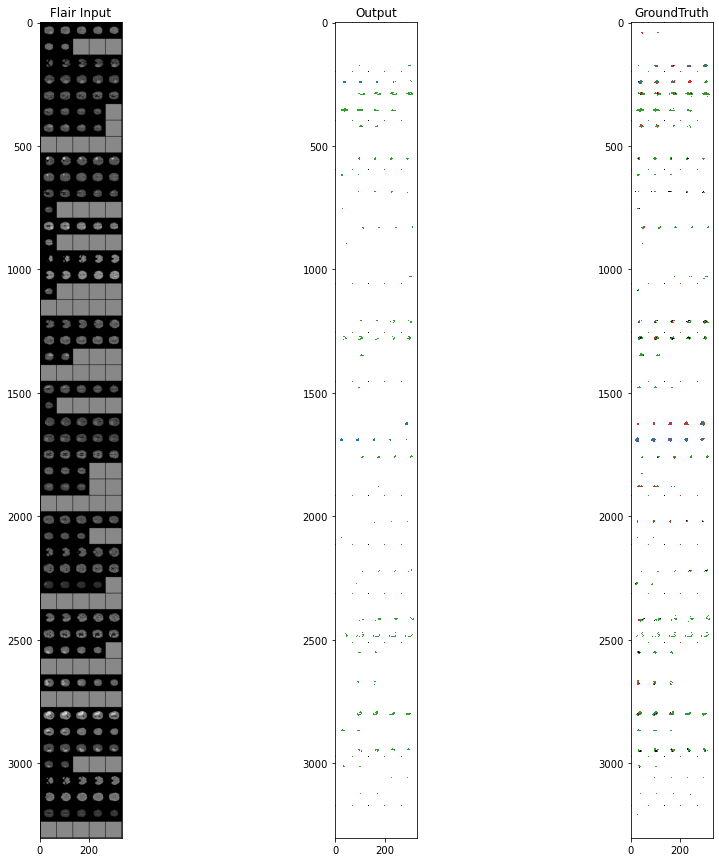

In [44]:
fig=plt.figure(figsize=(15,15))
fig.add_subplot(1, 3, 1)
plt.title("Flair Input") 
img = np.transpose(vutils.make_grid(data_flair.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 3, 2)
plt.title("Output")
plt_color_segments(output_image.view(-1, 4, 64, 64).detach().cpu(),values=(40,30,20,10), denoise=0.2)

fig.add_subplot(1, 3, 3)
plt.title("GroundTruth")
plt_color_segments(mask_cpu.view(-1, 4, 64, 64).detach().cpu())
plt.show()

## Test with conv2d lstm

In [13]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1, params=[], type_net='') -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim
        self.type_net = type_net
        if type_net=="conv_2d_lstm":
            self.conv2dlstm = Conv2DLSTM(ch_in=params[0], 
                  ch_out=params[1], 
                  kernal_size=params[2],
                  strides=params[3],
                  paddings=params[4],
                  lstm_step_size=params[5],
                  hidden_layer_size=params[6],
                  lstm_input_size=params[7],
                  lstm_output_size=params[8],
                  ngpu=1,).to(device)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            mdl_down, lstm, model_up = self.submodule
            mdl_down_x = mdl_down(x)
            #lstm_x = lstm(mdl_down_x)
            #lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
            #print("mdl_down_x", mdl_down_x.shape )
            #print("lstm_x", lstm_x.shape )
            res_x =  model_up(torch.cat([mdl_down_x, mdl_down_x], self.cat_dim))  
            #res_x =  model_up(lstm_x)  
            #print("res1", res_x.shape )
            return res_x
        elif self.type_net == "conv_2d_lstm":
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([self.conv2dlstm(x), self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        else:
             res = torch.cat([x, self.submodule(x)], self.cat_dim)
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        lstm_size: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.lstm_size = lstm_size
        self.strides = strides
        self.paddings = paddings
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int], lstm_size: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]
            l_size = lstm_size[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:], lstm_size[1:], False)  # continue recursion down
                upc = c * 2
                params = [c,c,(5,5),[1,1],[(2,2), (2,2)],lstm_step_size,hidden_layer_size,c,c] 
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1] + lstm_output_size
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d(upc_bottom, c + channels[1], 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c + channels[1], eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                ) 
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + channels[1]
                params=[]
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path
            
            if len(channels) > 3: 
                skip = SkipConnection(subblock, params=params, type_net="conv_2d_lstm")
            else:
                skip = SkipConnection(subblock, params=params, type_net="skip")
            
            return nn.Sequential(down, skip, up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, self.lstm_size, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )

    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )  
        if is_top:
             conv = nn.Sequential(
                            nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                            nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [36]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            lstm_size=[32,16,8,4,1],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

NameError: name 'Conv2DLSTM' is not defined

In [18]:

# Lists to keep track of progress
img_list = []
losses = []

In [ ]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.mean().item(), D_x))

        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/200][0/127]	Loss: 1.2892	D(x): 1.2892


In [141]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

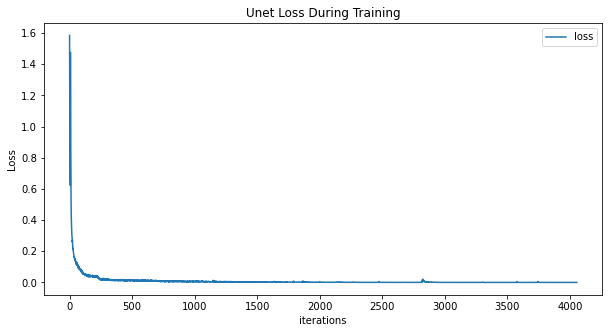

In [149]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [156]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(299) tensor(24) tensor(1278) tensor(64)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1256) tensor(715) tensor(3160) tensor(676)


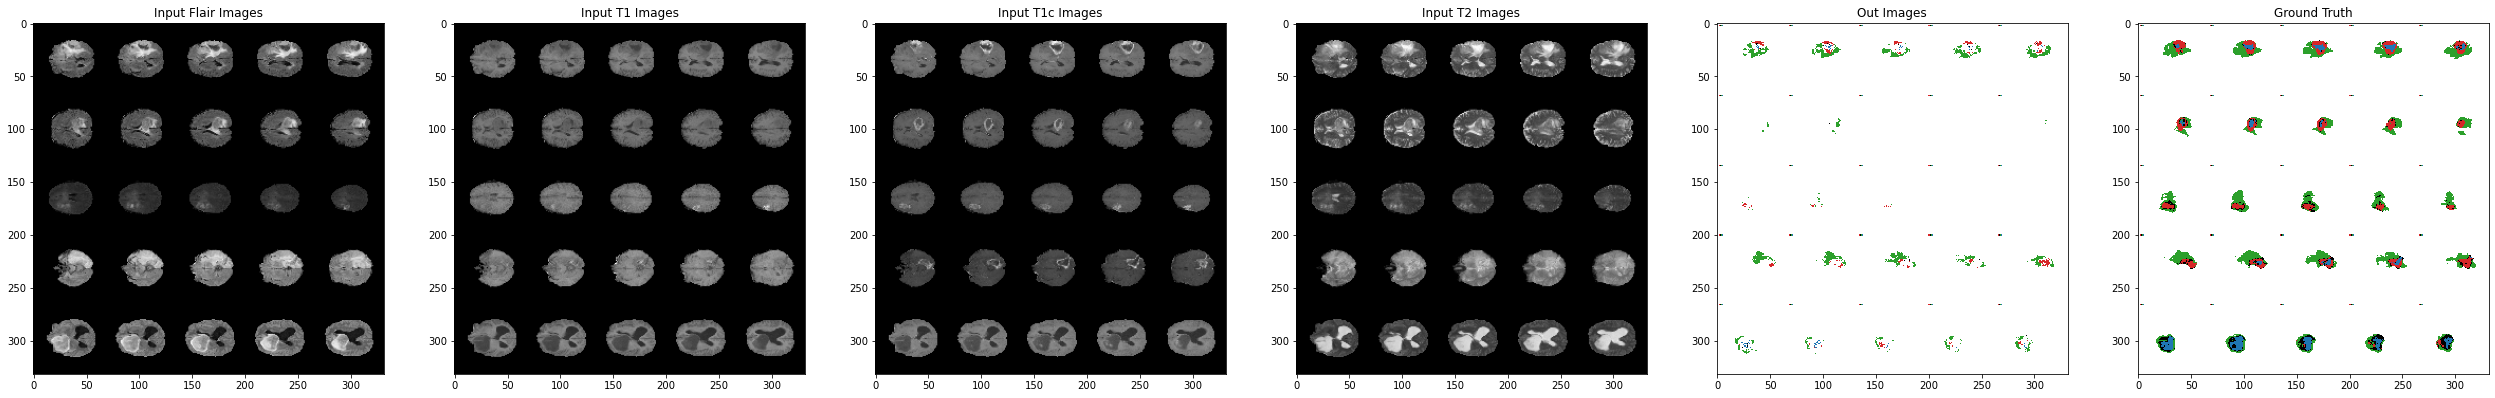

In [157]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu())

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [429]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [421]:
with open("Unet_lstm_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [422]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [430]:
output_list = [post_process(e) for e in output_list]

In [431]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [432]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5439], device='cuda:0')
tensor([0.4985], device='cuda:0')
tensor([0.2032], device='cuda:0')
tensor([0.], device='cuda:0')


In [350]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5402], device='cuda:0')
tensor([0.4879], device='cuda:0')
tensor([0.2026], device='cuda:0')
tensor([0.], device='cuda:0')


## unet with lstm conv2d

In [12]:
class LSTM(nn.Module):
    def __init__(self, ngpu, input_size=1, step_size=5,  hidden_layer_size=100, stack_nb=1, output_size=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size
        self.step_size = step_size
        self.input_size = input_size
        self.stack_nb = stack_nb
        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=bidirectional)

        
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
            
        self.linear = nn.Linear(hidden_layer_size*self.num_directions, output_size)
        
        #hidden and cell units
        self.hidden_cell = (torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device),
                            torch.zeros(stack_nb*self.num_directions, step_size, hidden_layer_size).to(device))
        #self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq): 
        self.hidden_cell_to_zero()
        if len(input_seq.shape) == 4:
            input_seq = input_seq.view(-1,self.step_size,self.input_size)
        print("input_seq.shape", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print("lstm_out.shape", lstm_out.shape)
        #predictions = self.linear(lstm_out.view(len(input_seq), -1, self.hidden_layer_size * self.num_directions))
        #print("predictions.shape", predictions.shape)
        return self.sigmoid(lstm_out)
        #return self.sigmoid(predictions)
    
    def hidden_cell_to_zero(self):
        self.hidden_cell = (torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device),
                            torch.zeros(self.stack_nb*self.num_directions, self.step_size, self.hidden_layer_size).to(device))

In [13]:

from monai.networks.nets import UNet

In [14]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias,transposed):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        if transposed:
            self.conv = nn.ConvTranspose2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias).to(device)
        else:
            self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias).to(device)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False,transposed=False,
                bidirectional=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)
        if bidirectional:
            num_layers *= 2
            
        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim[0], num_layers)
        #print(len(kernel_size), len(hidden_dim), num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        
            
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,transposed=transposed))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        layer_output_list_reverse = []
        last_state_list_reverse = []
        
        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor
        cur_layer_input_reverse = input_tensor

        for layer_idx in range(self.num_layers):
            if self.bidirectional and self.num_layers //2 <= layer_idx:
                loop_range = reversed(range(seq_len))
            else:
                loop_range = range(seq_len)
                
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in loop_range:
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            if self.bidirectional and self.num_layers //2 <= layer_idx:
                layer_output_reverse = torch.stack(output_inner, dim=1)
                cur_layer_input = layer_output
                
                layer_output_list_reverse.append(layer_output)
                last_state_list_reverse.append([h, c])
            else:
                layer_output = torch.stack(output_inner, dim=1)
                cur_layer_input = layer_output

                layer_output_list.append(layer_output)
                last_state_list.append([h, c])

        if not self.return_all_layers:
            if self.bidirectional:
                layer_output_list = [torch.cat([layer_output_list[-1], layer_output_list_reverse[-1]], dim=2)]
                last_state_list = last_state_list[-1:] + last_state_list_reverse[-1:]
            else:
                layer_output_list = layer_output_list[-1:]
                last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [15]:
class LSTMConvTranspose2D(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_dim, kernel_size,transposed,bidirectional):
        super(LSTMConvTranspose2D, self).__init__()
        
        self.model = ConvLSTM(input_dim=in_channel,
                     hidden_dim=[hidden_dim],
                     kernel_size=kernel_size,
                     num_layers=1,
                     batch_first=True,
                     bias=True,
                     return_all_layers=False,transposed=transposed,bidirectional=bidirectional).to(device)
        paddings = kernel_size[0]//2
        if bidirectional:
            self.mtp = 2
        else:
            self.mtp = 1
        if transposed:
            self.conv = nn.Sequential(
                    nn.ConvTranspose2d( hidden_dim*self.mtp, out_channel, kernel_size, 1, paddings, bias=False),
                    #nn.InstanceNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                    #nn.PReLU(num_parameters=1),
                    ).to(device)
        else:
            self.conv = nn.Sequential(
                    nn.Conv2d( hidden_dim*self.mtp, out_channel, kernel_size, 2, paddings, bias=False),
                    #nn.InstanceNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                    #nn.PReLU(num_parameters=1),
                   ).to(device)
                
        self.hidden_dim = hidden_dim
        self.in_channel = in_channel
        self.out_channel = out_channel
    def forward(self, x):
        x_shape = x.shape
        #print(x_shape)
        if len(x.shape) != 5:
            x = x.view(-1,lstm_step_size, self.in_channel,x_shape[-2],x_shape[-1])
            res,_ = self.model(x)
            res = res[0].view(-1,self.hidden_dim*self.mtp,x_shape[2],x_shape[3])
            res = self.conv(res)
            #print(res.shape)
            #print(res.view(-1,self.out_channel,x_shape[2],x_shape[3]).shape)
        else:
            print("make sure the shape is b,t,c,h,w", x.shape)
        return res.view(-1,self.out_channel,x_shape[2],x_shape[3])
        #return res[0].view(-1,self.out_channel,x_shape[2],x_shape[3])
        

In [16]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Sequence, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, export

class SkipConnection(nn.Module):
    """
    Concats the forward pass input with the result from the given submodule.
    """

    def __init__(self, submodule, cat_dim: int = 1) -> None:
        super().__init__()
        self.submodule = submodule 
        self.cat_dim = cat_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print("x.shape", x.shape)
        if isinstance(self.submodule, list): 
            mdl_down, lstm, model_up = self.submodule
            mdl_down_x = mdl_down(x)
            lstm_x = lstm(x)
            #lstm_x = lstm_x.view(-1,lstm_x.shape[2], mdl_down_x.shape[2], mdl_down_x.shape[3])
            #print("lstm_x", lstm_x.shape )
            #res_x =  model_up(torch.cat([mdl_down_x, lstm_x], self.cat_dim))  
            res_x =  model_up(mdl_down_x)
            #print("res1", res_x.shape )
            return torch.cat([x, res_x, lstm_x], self.cat_dim)
        else:
            #print(x.shape, self.submodule(x).shape)
            
            res = torch.cat([x, self.submodule(x)], self.cat_dim)
            #print("res2", res.shape )
        return res

     
@export("monai.networks.nets")
@alias("Unet")
class UNet(nn.Module):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act=Act.PRELU,
        norm=Norm.INSTANCE,
        dropout=0,
    ) -> None:
        """
        Enhanced version of UNet which has residual units implemented with the ResidualUnit class.
        The residual part uses a convolution to change the input dimensions to match the output dimensions
        if this is necessary but will use nn.Identity if not.
        Refer to: https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40.

        Args:
            dimensions: number of spatial dimensions.
            in_channels: number of input channels.
            out_channels: number of output channels.
            channels: sequence of channels. Top block first.
            strides: convolution stride.
            kernel_size: convolution kernel size. Defaults to 3.
            up_kernel_size: upsampling convolution kernel size. Defaults to 3.
            num_res_units: number of residual units. Defaults to 0.
            act: activation type and arguments. Defaults to PReLU.
            norm: feature normalization type and arguments. Defaults to instance norm.
            dropout: dropout ratio. Defaults to no dropout.
        """
        super().__init__()

        self.dimensions = dimensions
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.paddings = paddings
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], paddings: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.

            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]
            p = paddings[0]

            subblock: Union[nn.Sequential, ResidualUnit, Convolution]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], paddings[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer 
                #self.lstm = LSTM(ngpu=ngpu, input_size=nz, step_size=lstm_step_size, 
                #            hidden_layer_size=hidden_layer_size, output_size=lstm_output_size, 
                #            bidirectional=True)
                self.bottom_down = self._get_bottom_layer(c, channels[1], strides[1], paddings[1])
                upc_bottom = channels[1]
                self.bottom_up = nn.Sequential(
                            nn.ConvTranspose2d( upc_bottom, c, 4, 1, 0, bias=False),
                            nn.InstanceNorm2d(c, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                            nn.PReLU(num_parameters=1)
                )
                self.lstm = LSTMConvTranspose2D( c, c, hidden_dim=c, kernel_size=(3,3), transposed=True, bidirectional=True)
                subblock = [self.bottom_down, self.lstm, self.bottom_up] 
                upc = c + c + c
                
            down = self._get_down_layer(inc, c, s, p, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, p, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, self.paddings, True)

    def _get_down_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
        else:
            
            conv = nn.Sequential(
                    #SkipConnection(LSTMConvTranspose2D( in_channels, in_channels, hidden_dim=20, kernel_size=(3,3),transposed=False)),

                    nn.Conv2d( in_channels, out_channels, self.kernel_size, strides, paddings, bias=False),
                    nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                    nn.PReLU(num_parameters=1)
                )  
            return conv
            """ 
            return Convolution(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                padding=paddings,
                kernel_size=self.kernel_size,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
            )
            """ 
    def _get_bottom_layer(self, in_channels: int, out_channels: int, strides:int, paddings:int) -> Union[ResidualUnit, Convolution]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
        """
        return self._get_down_layer(in_channels, out_channels, strides, paddings, False)

    def _get_up_layer(
        self, in_channels: int, out_channels: int, strides: int, paddings: int, is_top: bool
    ) -> Union[Convolution, nn.Sequential]:
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        conv: Union[Convolution, nn.Sequential]

        conv = nn.Sequential(
                    LSTMConvTranspose2D( in_channels, out_channels, hidden_dim=out_channels, 
                                        kernel_size=(3,3), transposed=True,bidirectional=True),

                    #nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings, bias=False),
                    #nn.InstanceNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
                    #nn.PReLU(num_parameters=1),
                    nn.UpsamplingBilinear2d(scale_factor=2)
                    #nn.UpsamplingNearest2d(scale_factor=2)
                )  
        if is_top:
             conv = nn.Sequential(
                            #SkipConnection(LSTMConvTranspose2D( in_channels, in_channels, hidden_dim=20, kernel_size=(3,3), transposed=True)),
                       nn.ConvTranspose2d( in_channels, out_channels, self.up_kernel_size, strides, paddings,  bias=False),
                       nn.Tanh()
                )  
        #print(in_channels, out_channels,strides,paddings,self.up_kernel_size,)

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                padding=paddings,
                output_padding=paddings,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = unet = UNet


In [17]:
unet = UNet(dimensions=2, 
            in_channels=4,
            out_channels=4, 
            channels =[64,128,256,512,nz], 
            strides=[2,2,2,2,1],
            paddings=[1,1,1,1,0],
            kernel_size=4,
            up_kernel_size=4
           ).to(device)
#unet.apply(weights_init)
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

unet

# Setup Adam optimizers for both G and D
optimizerUNet = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, 0.999)) 
print(unet)

UNet(
  (bottom_down): Sequential(
    (0): LSTMConvTranspose2D(
      (model): ConvLSTM(
        (cell_list): ModuleList(
          (0): ConvLSTMCell(
            (conv): Conv2d(812, 1200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ConvLSTMCell(
            (conv): Conv2d(600, 1200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (conv): Sequential(
        (0): Conv2d(600, 300, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
    )
    (1): PReLU(num_parameters=1)
  )
  (bottom_up): Sequential(
    (0): ConvTranspose2d(300, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
  )
  (lstm): LSTMConvTranspose2D(
    (model): ConvLSTM(
      (cell_list): ModuleList(
        (0): ConvLSTMCell(
          (conv): ConvTranspose2d(1024, 2048, kernel_size=(3, 3), stride=(1,

In [18]:
# Lists to keep track of progress
img_list = []
losses = []

In [19]:
# Training Loop


iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_flair,data_t1,data_t1c,data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        img_shape = data_flair.shape
        #print("data_flair.shape", data_flair.shape)
        
        real_cpu = torch.cat((data_flair.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t1c.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              data_t2.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2)
        mask_cpu = data_ot.view(-1, 4, img_shape[2], img_shape[3]) 
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]
        
        unet.zero_grad() 
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
         
        # Calculate loss on all-real batch 
        err = mesloss(output, mask_cpu) 
        
        # Calculate gradients for G
        err.backward() 
        D_x = err.mean().item()
        
        # Update 
        optimizerUNet.step() 
        #err.backward() 
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),  D_x)) 
            
        # Save Losses for plotting later
        losses.append(err.mean().item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            pass
            #images_to_plot = torch.cat((mask_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            #img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...


RuntimeError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 8.00 GiB total capacity; 5.66 GiB already allocated; 64.97 MiB free; 5.88 GiB reserved in total by PyTorch)

In [ ]:
with open("unet_loss.pkl", "wb") as f:
    pkl.dump(losses, f)

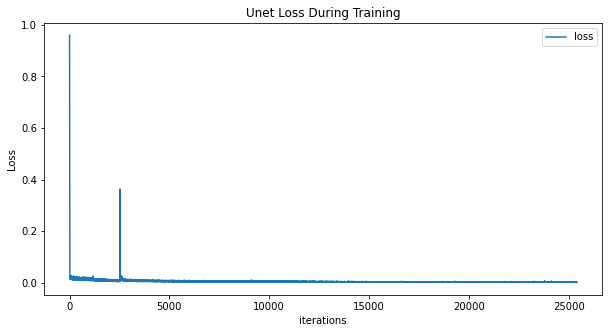

In [38]:
plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
size_test = 5
selected_index = [43, 243, 174, 329, 402]
print(selected_index)
fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

[43, 243, 174, 329, 402]


tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1413) tensor(559) tensor(4362) tensor(684)
tensor(1.) tensor(1.) tensor(1.) tensor(1.)
tensor(1562) tensor(893) tensor(5029) tensor(764)


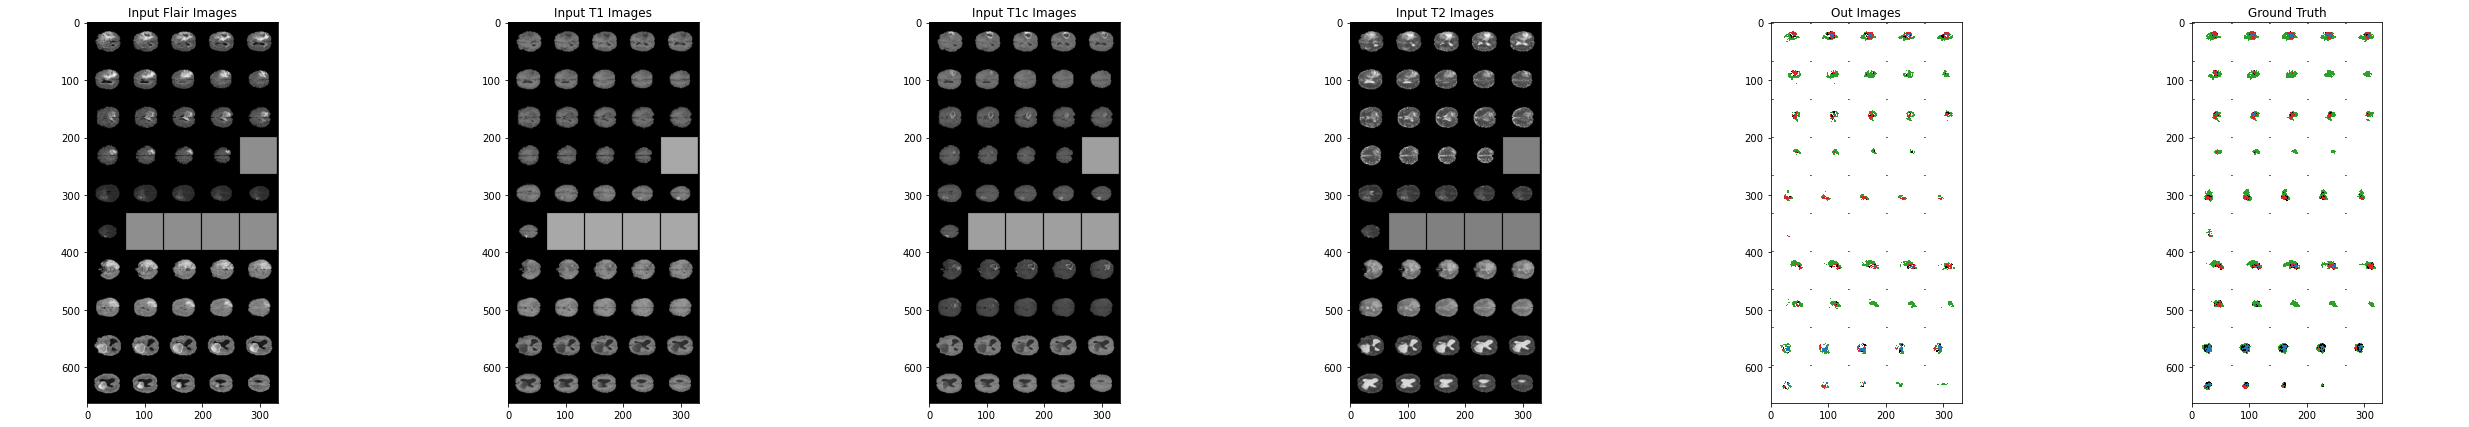

In [40]:
with torch.no_grad():
    img_shape = fixed_Flair_image.shape
    #print("data_flair.shape", data_flair.shape)

    real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                          fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                          ), dim=2).to(device)
    ground_truth = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = img_shape[0]
    
    
    # Since we just updated D, perform another forward pass of all-fake batch through D
    #print(real_cpu.shape)
    output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])
   


    

# Plot some training images 
fig=plt.figure(figsize=(44,7))
plt.axis("off")

fig.add_subplot(1, 6, 1)
plt.title("Input Flair Images")
img = np.transpose(vutils.make_grid(fixed_Flair_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 2)
plt.title("Input T1 Images")
img = np.transpose(vutils.make_grid(fixed_T1_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 3)
plt.title("Input T1c Images")
img = np.transpose(vutils.make_grid(fixed_T1c_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 4)
plt.title("Input T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image.view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(1, 6, 5)
plt.title("Out Images") 
#img = np.transpose(vutils.make_grid(oupt_simple, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(output.view(-1, 4, 64, 64).cpu(),denoise=0.1)

fig.add_subplot(1, 6, 6)
plt.title("Ground Truth")

#img = np.transpose(vutils.make_grid(ground_truth.view(-1, 4, 64, 64).sum(dim=1).view(-1, 1, 64, 64), padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
#plt.imshow(img,cmap='jet')

plt_color_segments(ground_truth.view(-1, 4, 64, 64).cpu())
 
plt.show()

In [41]:
output_list = []
ground_truth_list = []
with torch.no_grad():
    for i in range(0, len(ds_test), batch_size):
        
    
        selected_index = range(i, min(i+batch_size, len(ds_test)))
        
        fixed_Flair_image = torch.stack([ds_test[i][0] for i in selected_index]).to(device) # 1 batch
        fixed_T1_image = torch.stack([ds_test[i][1] for i in selected_index]).to(device) # 1 batch
        fixed_T1c_image = torch.stack([ds_test[i][2] for i in selected_index]).to(device) # 1 batch
        fixed_T2_image = torch.stack([ds_test[i][3] for i in selected_index]).to(device) # 1 batch
        fixed_OT_image = torch.stack([ds_test[i][4] for i in selected_index]).to(device)

        img_shape = fixed_Flair_image.shape
        real_cpu = torch.cat((fixed_Flair_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T1c_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3]), 
                              fixed_T2_image.view(img_shape[0], img_shape[1], 1, img_shape[2], img_shape[3])
                              ), dim=2).to(device)
        ground_truth = fixed_OT_image
        #print("real_cpu.shape", real_cpu.shape)
        b_size = img_shape[0]

    
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        output = unet(real_cpu.view(-1, 4, img_shape[2], img_shape[3])).view(-1, 4, img_shape[2], img_shape[3])



        #print("output.shape", output.shape)
        output_list.append(output)
        ground_truth_list.append(ground_truth)
        

In [37]:
with open("Unet_predictions.pkl", "wb") as f:
    pkl.dump(output_list, f)

In [42]:
def post_process(tsr, denoise=0.0,to_binary=True,de_overlap=False):
    if denoise > 0: 
        tsr -= denoise
    if to_binary:
        tsr[tsr>0] = 1
        tsr[tsr<=0] = 0
    if de_overlap:
        idx = [2,3,1,0]
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                pass
    return tsr

In [43]:
from monai.metrics import compute_meandice, compute_hausdorff_distance, DiceMetric

In [44]:
dice = DiceMetric()

In [45]:
output_list = [post_process(e) for e in output_list]

In [46]:
ground_truth_list = [post_process(e) for e in ground_truth_list]

In [47]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.6219], device='cuda:0')
tensor([0.0880], device='cuda:0')
tensor([0.4901], device='cuda:0')
tensor([0.3445], device='cuda:0')


In [47]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.6219], device='cuda:0')
tensor([0.0880], device='cuda:0')
tensor([0.4901], device='cuda:0')
tensor([0.3445], device='cuda:0')


In [54]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.6185], device='cuda:0')
tensor([0.0742], device='cuda:0')
tensor([0.4698], device='cuda:0')
tensor([0.2993], device='cuda:0')


In [31]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5307], device='cuda:0')
tensor([0.0770], device='cuda:0')
tensor([0.4701], device='cuda:0')
tensor([0.2704], device='cuda:0')


In [33]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.5124], device='cuda:0')
tensor([0.0862], device='cuda:0')
tensor([0.4663], device='cuda:0')
tensor([0.2906], device='cuda:0')


In [122]:
x1 = torch.cat(output_list, dim=0)
y = torch.cat(ground_truth_list, dim=0)
for i in range(4):
    res = dice(x1.view(-1,4,64,64)[:, i,:,:], y.view(-1,4,64,64)[:, i,:,:])
    print(res)

tensor([0.4850], device='cuda:0')
tensor([0.0570], device='cuda:0')
tensor([0.4287], device='cuda:0')
tensor([0.1927], device='cuda:0')
